In [1]:
# ===============================================================
# Cell 1: প্যাকেজ ইনস্টল (Dependencies)
# ===============================================================
!pip install protobuf==4.23.3 -q
!pip install thop --no-cache-dir -q
!pip install umap-learn -q

print("✅ সব প্যাকেজ ইনস্টল হয়েছে")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.23.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 4.23.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.23.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 4.23.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

In [2]:
# ===============================================================
# Cell 2: লাইব্রেরি Import
# ===============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import umap.umap_ as umap
from thop import profile
import time, os, random, copy

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ সব লাইব্রেরি লোড হয়েছে")

2025-12-15 17:48:09.596434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765820889.831001      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765820889.899805      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ সব লাইব্রেরি লোড হয়েছে


In [3]:
# ===============================================================
# Cell 3: Device Setup
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ ডিভাইস: {device}")



✅ ডিভাইস: cuda


In [4]:
# ===============================================================
# Cell 4: Dataset Path এবং Augmentation (FIXED)
# ===============================================================
DATA_DIR = "/kaggle/input/microscopic-dataset-of-plant-parasitic-nematodes"

# BYOL এর জন্য দুটি আলাদা augmentation pipeline
class TwoViewTransform:
    """দুটি আলাদা augmented view তৈরি করে"""
    def __init__(self, base_transform):
        self.base_transform = base_transform
    
    def __call__(self, x):
        view1 = self.base_transform(x)
        view2 = self.base_transform(x)
        return view1, view2

ssl_base_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
    transforms.RandomApply([transforms.RandomRotation(30)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# SSL dataset with two views
ssl_dataset = datasets.ImageFolder(DATA_DIR, transform=TwoViewTransform(ssl_base_transform))
eval_dataset = datasets.ImageFolder(DATA_DIR, transform=eval_transform)

print(f"✅ Dataset size: {len(eval_dataset)}")
print(f"✅ Classes: {eval_dataset.classes}")
print(f"✅ Number of classes: {len(eval_dataset.classes)}")


✅ Dataset size: 1012
✅ Classes: ['Genus Criconemoides', 'Genus Helicotylenchus', 'Genus Hemicycliophora', 'Genus Hirschmaniella', 'Genus Hoplolaimus', 'Genus Meloidogyne', 'Genus Pratylenchus', 'Genus Radopholus', 'Genus Trichodorus', 'Genus Xiphinema']
✅ Number of classes: 10


In [5]:
# ===============================================================
# Cell 5: Train/Val/Test Split - COMPLETE FIXED VERSION
# ===============================================================
from sklearn.model_selection import train_test_split

print("📊 Creating train/val/test splits...\n")

# Get all labels from dataset
all_targets = eval_dataset.targets if hasattr(eval_dataset, 'targets') else \
              [eval_dataset[i][1] for i in range(len(eval_dataset))]

# First split: train+val vs test (90% vs 10%)
train_val_indices, test_indices = train_test_split(
    list(range(len(eval_dataset))), 
    test_size=0.1, 
    stratify=all_targets,
    random_state=42
)

# Second split: train vs val (90% vs 10% of train+val)
train_val_targets = [all_targets[i] for i in train_val_indices]
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.1,
    stratify=train_val_targets,
    random_state=42
)

# Create Subset datasets
ssl_train_dataset = Subset(ssl_dataset, train_indices)
train_dataset = Subset(eval_dataset, train_indices)
val_dataset = Subset(eval_dataset, val_indices)
test_dataset = Subset(eval_dataset, test_indices)

print(f"✅ SSL Train: {len(ssl_train_dataset):4d} samples")
print(f"✅ Train:     {len(train_dataset):4d} samples")
print(f"✅ Val:       {len(val_dataset):4d} samples")
print(f"✅ Test:      {len(test_dataset):4d} samples")

# Verify class distribution
train_labels = [all_targets[i] for i in train_indices]
val_labels = [all_targets[i] for i in val_indices]
test_labels = [all_targets[i] for i in test_indices]

print(f"\n📋 Class Distribution:")
print(f"   Train: {len(set(train_labels))}/{len(eval_dataset.classes)} classes")
print(f"   Val:   {len(set(val_labels))}/{len(eval_dataset.classes)} classes")
print(f"   Test:  {len(set(test_labels))}/{len(eval_dataset.classes)} classes")

# ✅ Store indices for later use (label efficiency)
# These will be available globally
print(f"\n✅ Indices stored: train_indices, val_indices, test_indices")

📊 Creating train/val/test splits...

✅ SSL Train:  819 samples
✅ Train:      819 samples
✅ Val:         91 samples
✅ Test:       102 samples

📋 Class Distribution:
   Train: 10/10 classes
   Val:   9/10 classes
   Test:  10/10 classes

✅ Indices stored: train_indices, val_indices, test_indices


In [6]:
# ===============================================================
# Cell 6: DataLoaders
# ===============================================================
batch_size = 32
num_workers = 2

ssl_loader = DataLoader(ssl_train_dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=num_workers, drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print(f"✅ DataLoaders তৈরি হয়েছে")

✅ DataLoaders তৈরি হয়েছে


In [7]:
# ===============================================================
# Cell 7: BYOL Model Definition (FIXED)
# ===============================================================
class projection_MLP(nn.Module):
    def __init__(self, in_dim=2048, hidden_dim=4096, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class prediction_MLP(nn.Module):
    def __init__(self, in_dim=256, hidden_dim=4096, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class BYOL(nn.Module):
    def __init__(self, base_encoder):
        super().__init__()
        
        # Online network
        self.online_encoder = base_encoder
        self.online_projector = projection_MLP()
        self.online_predictor = prediction_MLP()
        
        # Target network (EMA)
        self.target_encoder = copy.deepcopy(base_encoder)
        self.target_projector = copy.deepcopy(self.online_projector)
        
        # Freeze target
        for p in self.target_encoder.parameters():
            p.requires_grad = False
        for p in self.target_projector.parameters():
            p.requires_grad = False
    
    @torch.no_grad()
    def _update_target_network(self, momentum=0.996):
        """EMA update for target network"""
        for p_o, p_t in zip(self.online_encoder.parameters(), 
                            self.target_encoder.parameters()):
            p_t.data = momentum * p_t.data + (1 - momentum) * p_o.data
        
        for p_o, p_t in zip(self.online_projector.parameters(), 
                            self.target_projector.parameters()):
            p_t.data = momentum * p_t.data + (1 - momentum) * p_o.data
    
    def forward(self, x1, x2):
        # Online predictions
        o1 = self.online_predictor(self.online_projector(self.online_encoder(x1)))
        o2 = self.online_predictor(self.online_projector(self.online_encoder(x2)))
        
        # Target projections (no gradient)
        with torch.no_grad():
            t1 = self.target_projector(self.target_encoder(x1))
            t2 = self.target_projector(self.target_encoder(x2))
        
        return o1, t2.detach(), o2, t1.detach()

print("✅ BYOL Model ডিফাইন হয়েছে")

✅ BYOL Model ডিফাইন হয়েছে


In [8]:
# ===============================================================
# Cell 8: BYOL Loss Function
# ===============================================================
def byol_loss(p, z):
    """
    BYOL loss: negative cosine similarity
    p: predictor output (batch_size, dim)
    z: target projection (batch_size, dim)
    """
    p = F.normalize(p, dim=-1, p=2)
    z = F.normalize(z, dim=-1, p=2)
    return 2 - 2 * (p * z).sum(dim=-1)

print("✅ Loss function তৈরি হয়েছে")

✅ Loss function তৈরি হয়েছে


In [9]:
# ===============================================================
# Cell 9: Initialize BYOL Model
# ===============================================================
# Load pretrained ResNet50
base_encoder = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
base_encoder.fc = nn.Identity()  # Remove classification head
base_encoder = base_encoder.to(device)

# Create BYOL model
model = BYOL(base_encoder).to(device)

# Optimizer (শুধু online network এর জন্য)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

print("✅ BYOL Model initialize হয়েছে")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


✅ BYOL Model initialize হয়েছে



🔥 BYOL SSL Pretraining শুরু হচ্ছে...



Epoch 1/400: 100%|██████████| 25/25 [01:24<00:00,  3.39s/it, loss=1.5820]


Epoch 1/400 | SSL Loss: 1.9096 | LR: 0.000100
✅ Best model saved at epoch 1


Epoch 2/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=1.4692]


Epoch 2/400 | SSL Loss: 1.5007 | LR: 0.000100
✅ Best model saved at epoch 2


Epoch 3/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=1.3289]


Epoch 3/400 | SSL Loss: 1.4092 | LR: 0.000099
✅ Best model saved at epoch 3


Epoch 4/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=1.2217]


Epoch 4/400 | SSL Loss: 1.3165 | LR: 0.000098
✅ Best model saved at epoch 4


Epoch 5/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=1.0829]


Epoch 5/400 | SSL Loss: 1.1821 | LR: 0.000098
✅ Best model saved at epoch 5


Epoch 6/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=1.1135]


Epoch 6/400 | SSL Loss: 1.0399 | LR: 0.000097
✅ Best model saved at epoch 6


Epoch 7/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.7937]


Epoch 7/400 | SSL Loss: 0.9248 | LR: 0.000095
✅ Best model saved at epoch 7


Epoch 8/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.7718]


Epoch 8/400 | SSL Loss: 0.7831 | LR: 0.000094
✅ Best model saved at epoch 8


Epoch 9/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.6453]


Epoch 9/400 | SSL Loss: 0.6710 | LR: 0.000092
✅ Best model saved at epoch 9


Epoch 10/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.5888]


Epoch 10/400 | SSL Loss: 0.6048 | LR: 0.000091
✅ Best model saved at epoch 10


Epoch 11/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.5811]


Epoch 11/400 | SSL Loss: 0.5613 | LR: 0.000089
✅ Best model saved at epoch 11


Epoch 12/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.5815]


Epoch 12/400 | SSL Loss: 0.5192 | LR: 0.000087
✅ Best model saved at epoch 12


Epoch 13/400: 100%|██████████| 25/25 [01:27<00:00,  3.50s/it, loss=0.3994]


Epoch 13/400 | SSL Loss: 0.4654 | LR: 0.000084
✅ Best model saved at epoch 13


Epoch 14/400: 100%|██████████| 25/25 [01:22<00:00,  3.28s/it, loss=0.4646]


Epoch 14/400 | SSL Loss: 0.4472 | LR: 0.000082
✅ Best model saved at epoch 14


Epoch 15/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.5510]


Epoch 15/400 | SSL Loss: 0.3882 | LR: 0.000080
✅ Best model saved at epoch 15


Epoch 16/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.3732]


Epoch 16/400 | SSL Loss: 0.3888 | LR: 0.000077


Epoch 17/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.3229]


Epoch 17/400 | SSL Loss: 0.3525 | LR: 0.000074
✅ Best model saved at epoch 17


Epoch 18/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.3312]


Epoch 18/400 | SSL Loss: 0.3427 | LR: 0.000072
✅ Best model saved at epoch 18


Epoch 19/400: 100%|██████████| 25/25 [01:24<00:00,  3.40s/it, loss=0.5299]


Epoch 19/400 | SSL Loss: 0.3209 | LR: 0.000069
✅ Best model saved at epoch 19


Epoch 20/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.3821]


Epoch 20/400 | SSL Loss: 0.3220 | LR: 0.000066


Epoch 21/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2774]


Epoch 21/400 | SSL Loss: 0.3142 | LR: 0.000063
✅ Best model saved at epoch 21


Epoch 22/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.2447]


Epoch 22/400 | SSL Loss: 0.3008 | LR: 0.000060
✅ Best model saved at epoch 22


Epoch 23/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.2839]


Epoch 23/400 | SSL Loss: 0.2970 | LR: 0.000057
✅ Best model saved at epoch 23


Epoch 24/400: 100%|██████████| 25/25 [01:22<00:00,  3.32s/it, loss=0.2881]


Epoch 24/400 | SSL Loss: 0.2704 | LR: 0.000054
✅ Best model saved at epoch 24


Epoch 25/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.2841]


Epoch 25/400 | SSL Loss: 0.2628 | LR: 0.000050
✅ Best model saved at epoch 25


Epoch 26/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.2125]


Epoch 26/400 | SSL Loss: 0.2570 | LR: 0.000047
✅ Best model saved at epoch 26


Epoch 27/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.1613]


Epoch 27/400 | SSL Loss: 0.2598 | LR: 0.000044


Epoch 28/400: 100%|██████████| 25/25 [01:17<00:00,  3.12s/it, loss=0.1528]


Epoch 28/400 | SSL Loss: 0.2259 | LR: 0.000041
✅ Best model saved at epoch 28


Epoch 29/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1576]


Epoch 29/400 | SSL Loss: 0.2159 | LR: 0.000038
✅ Best model saved at epoch 29


Epoch 30/400: 100%|██████████| 25/25 [01:17<00:00,  3.12s/it, loss=0.2054]


Epoch 30/400 | SSL Loss: 0.2271 | LR: 0.000035


Epoch 31/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2296]


Epoch 31/400 | SSL Loss: 0.2335 | LR: 0.000032


Epoch 32/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.2183]


Epoch 32/400 | SSL Loss: 0.2310 | LR: 0.000029


Epoch 33/400: 100%|██████████| 25/25 [01:24<00:00,  3.39s/it, loss=0.1302]


Epoch 33/400 | SSL Loss: 0.1977 | LR: 0.000027
✅ Best model saved at epoch 33


Epoch 34/400: 100%|██████████| 25/25 [01:26<00:00,  3.46s/it, loss=0.2298]


Epoch 34/400 | SSL Loss: 0.2089 | LR: 0.000024


Epoch 35/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.2540]


Epoch 35/400 | SSL Loss: 0.2051 | LR: 0.000021


Epoch 36/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2404]


Epoch 36/400 | SSL Loss: 0.2163 | LR: 0.000019


Epoch 37/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.1788]


Epoch 37/400 | SSL Loss: 0.1995 | LR: 0.000017


Epoch 38/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1951]


Epoch 38/400 | SSL Loss: 0.2056 | LR: 0.000014


Epoch 39/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1922]


Epoch 39/400 | SSL Loss: 0.1852 | LR: 0.000012
✅ Best model saved at epoch 39


Epoch 40/400: 100%|██████████| 25/25 [01:17<00:00,  3.09s/it, loss=0.1570]


Epoch 40/400 | SSL Loss: 0.1816 | LR: 0.000010
✅ Best model saved at epoch 40


Epoch 41/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.1756]


Epoch 41/400 | SSL Loss: 0.2003 | LR: 0.000009


Epoch 42/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1498]


Epoch 42/400 | SSL Loss: 0.1896 | LR: 0.000007


Epoch 43/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.2489]


Epoch 43/400 | SSL Loss: 0.1948 | LR: 0.000006


Epoch 44/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1977]


Epoch 44/400 | SSL Loss: 0.1793 | LR: 0.000004
✅ Best model saved at epoch 44


Epoch 45/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.1168]


Epoch 45/400 | SSL Loss: 0.2033 | LR: 0.000003


Epoch 46/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2446]


Epoch 46/400 | SSL Loss: 0.1906 | LR: 0.000003


Epoch 47/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.2602]


Epoch 47/400 | SSL Loss: 0.1738 | LR: 0.000002
✅ Best model saved at epoch 47


Epoch 48/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1718]


Epoch 48/400 | SSL Loss: 0.1772 | LR: 0.000001


Epoch 49/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.3993]


Epoch 49/400 | SSL Loss: 0.1865 | LR: 0.000001


Epoch 50/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.1575]


Epoch 50/400 | SSL Loss: 0.1685 | LR: 0.000001
✅ Best model saved at epoch 50


Epoch 51/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.1630]


Epoch 51/400 | SSL Loss: 0.1769 | LR: 0.000001


Epoch 52/400: 100%|██████████| 25/25 [01:16<00:00,  3.06s/it, loss=0.1438]


Epoch 52/400 | SSL Loss: 0.1844 | LR: 0.000001


Epoch 53/400: 100%|██████████| 25/25 [01:15<00:00,  3.02s/it, loss=0.1366]


Epoch 53/400 | SSL Loss: 0.1791 | LR: 0.000002


Epoch 54/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.2766]


Epoch 54/400 | SSL Loss: 0.1904 | LR: 0.000003


Epoch 55/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1353]


Epoch 55/400 | SSL Loss: 0.1747 | LR: 0.000003


Epoch 56/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.2087]


Epoch 56/400 | SSL Loss: 0.1902 | LR: 0.000004


Epoch 57/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.3755]


Epoch 57/400 | SSL Loss: 0.1811 | LR: 0.000006


Epoch 58/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1263]


Epoch 58/400 | SSL Loss: 0.2083 | LR: 0.000007


Epoch 59/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1857]


Epoch 59/400 | SSL Loss: 0.1786 | LR: 0.000009


Epoch 60/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1318]


Epoch 60/400 | SSL Loss: 0.1728 | LR: 0.000010


Epoch 61/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.2852]


Epoch 61/400 | SSL Loss: 0.1755 | LR: 0.000012


Epoch 62/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.1106]


Epoch 62/400 | SSL Loss: 0.1825 | LR: 0.000014


Epoch 63/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1739]


Epoch 63/400 | SSL Loss: 0.1819 | LR: 0.000017


Epoch 64/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1633]


Epoch 64/400 | SSL Loss: 0.1698 | LR: 0.000019


Epoch 65/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1799]


Epoch 65/400 | SSL Loss: 0.1927 | LR: 0.000021


Epoch 66/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1583]


Epoch 66/400 | SSL Loss: 0.1674 | LR: 0.000024
✅ Best model saved at epoch 66


Epoch 67/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.2255]


Epoch 67/400 | SSL Loss: 0.2016 | LR: 0.000027


Epoch 68/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1348]


Epoch 68/400 | SSL Loss: 0.1683 | LR: 0.000029


Epoch 69/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.2086]


Epoch 69/400 | SSL Loss: 0.1746 | LR: 0.000032


Epoch 70/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1788]


Epoch 70/400 | SSL Loss: 0.2077 | LR: 0.000035


Epoch 71/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1342]


Epoch 71/400 | SSL Loss: 0.1737 | LR: 0.000038


Epoch 72/400: 100%|██████████| 25/25 [01:16<00:00,  3.07s/it, loss=0.1339]


Epoch 72/400 | SSL Loss: 0.1804 | LR: 0.000041


Epoch 73/400: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it, loss=0.1595]


Epoch 73/400 | SSL Loss: 0.1957 | LR: 0.000044


Epoch 74/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1642]


Epoch 74/400 | SSL Loss: 0.1832 | LR: 0.000047


Epoch 75/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.1553]


Epoch 75/400 | SSL Loss: 0.1823 | LR: 0.000050


Epoch 76/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1550]


Epoch 76/400 | SSL Loss: 0.1765 | LR: 0.000054


Epoch 77/400: 100%|██████████| 25/25 [01:23<00:00,  3.33s/it, loss=0.2989]


Epoch 77/400 | SSL Loss: 0.1807 | LR: 0.000057


Epoch 78/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1742]


Epoch 78/400 | SSL Loss: 0.1723 | LR: 0.000060


Epoch 79/400: 100%|██████████| 25/25 [01:23<00:00,  3.34s/it, loss=0.1670]


Epoch 79/400 | SSL Loss: 0.1851 | LR: 0.000063


Epoch 80/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.2286]


Epoch 80/400 | SSL Loss: 0.1768 | LR: 0.000066


Epoch 81/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.1323]


Epoch 81/400 | SSL Loss: 0.1666 | LR: 0.000069
✅ Best model saved at epoch 81


Epoch 82/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1490]


Epoch 82/400 | SSL Loss: 0.1808 | LR: 0.000072


Epoch 83/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2350]


Epoch 83/400 | SSL Loss: 0.1889 | LR: 0.000074


Epoch 84/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.2915]


Epoch 84/400 | SSL Loss: 0.1870 | LR: 0.000077


Epoch 85/400: 100%|██████████| 25/25 [01:18<00:00,  3.12s/it, loss=0.2599]


Epoch 85/400 | SSL Loss: 0.1721 | LR: 0.000080


Epoch 86/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1840]


Epoch 86/400 | SSL Loss: 0.1872 | LR: 0.000082


Epoch 87/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1968]


Epoch 87/400 | SSL Loss: 0.2136 | LR: 0.000084


Epoch 88/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.1485]


Epoch 88/400 | SSL Loss: 0.1713 | LR: 0.000087


Epoch 89/400: 100%|██████████| 25/25 [01:16<00:00,  3.07s/it, loss=0.2836]


Epoch 89/400 | SSL Loss: 0.1818 | LR: 0.000089


Epoch 90/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.2956]


Epoch 90/400 | SSL Loss: 0.1914 | LR: 0.000091


Epoch 91/400: 100%|██████████| 25/25 [01:15<00:00,  3.01s/it, loss=0.1322]


Epoch 91/400 | SSL Loss: 0.2010 | LR: 0.000092


Epoch 92/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.2275]


Epoch 92/400 | SSL Loss: 0.1948 | LR: 0.000094


Epoch 93/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.1031]


Epoch 93/400 | SSL Loss: 0.1914 | LR: 0.000095


Epoch 94/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.3186]


Epoch 94/400 | SSL Loss: 0.2014 | LR: 0.000097


Epoch 95/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.2702]


Epoch 95/400 | SSL Loss: 0.1808 | LR: 0.000098


Epoch 96/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1719]


Epoch 96/400 | SSL Loss: 0.1869 | LR: 0.000098


Epoch 97/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1406]


Epoch 97/400 | SSL Loss: 0.1829 | LR: 0.000099


Epoch 98/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1846]


Epoch 98/400 | SSL Loss: 0.1689 | LR: 0.000100


Epoch 99/400: 100%|██████████| 25/25 [01:23<00:00,  3.33s/it, loss=0.1564]


Epoch 99/400 | SSL Loss: 0.1778 | LR: 0.000100


Epoch 100/400: 100%|██████████| 25/25 [01:24<00:00,  3.37s/it, loss=0.1270]


Epoch 100/400 | SSL Loss: 0.1746 | LR: 0.000100


Epoch 101/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1884]


Epoch 101/400 | SSL Loss: 0.1665 | LR: 0.000100
✅ Best model saved at epoch 101


Epoch 102/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.1271]


Epoch 102/400 | SSL Loss: 0.1734 | LR: 0.000100


Epoch 103/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1575]


Epoch 103/400 | SSL Loss: 0.1719 | LR: 0.000099


Epoch 104/400: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it, loss=0.1298]


Epoch 104/400 | SSL Loss: 0.1759 | LR: 0.000098


Epoch 105/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1781]


Epoch 105/400 | SSL Loss: 0.1686 | LR: 0.000098


Epoch 106/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1336]


Epoch 106/400 | SSL Loss: 0.1655 | LR: 0.000097
✅ Best model saved at epoch 106


Epoch 107/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2665]


Epoch 107/400 | SSL Loss: 0.1619 | LR: 0.000095
✅ Best model saved at epoch 107


Epoch 108/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1333]


Epoch 108/400 | SSL Loss: 0.1621 | LR: 0.000094


Epoch 109/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1312]


Epoch 109/400 | SSL Loss: 0.1710 | LR: 0.000092


Epoch 110/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1750]


Epoch 110/400 | SSL Loss: 0.1641 | LR: 0.000091


Epoch 111/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.2028]


Epoch 111/400 | SSL Loss: 0.1620 | LR: 0.000089


Epoch 112/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1658]


Epoch 112/400 | SSL Loss: 0.1615 | LR: 0.000087
✅ Best model saved at epoch 112


Epoch 113/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1936]


Epoch 113/400 | SSL Loss: 0.1760 | LR: 0.000084


Epoch 114/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.0918]


Epoch 114/400 | SSL Loss: 0.1512 | LR: 0.000082
✅ Best model saved at epoch 114


Epoch 115/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1307]


Epoch 115/400 | SSL Loss: 0.1417 | LR: 0.000080
✅ Best model saved at epoch 115


Epoch 116/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1839]


Epoch 116/400 | SSL Loss: 0.1455 | LR: 0.000077


Epoch 117/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.1894]


Epoch 117/400 | SSL Loss: 0.1524 | LR: 0.000074


Epoch 118/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1967]


Epoch 118/400 | SSL Loss: 0.1602 | LR: 0.000072


Epoch 119/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1563]


Epoch 119/400 | SSL Loss: 0.1549 | LR: 0.000069


Epoch 120/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1853]


Epoch 120/400 | SSL Loss: 0.1396 | LR: 0.000066
✅ Best model saved at epoch 120


Epoch 121/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1176]


Epoch 121/400 | SSL Loss: 0.1451 | LR: 0.000063


Epoch 122/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1945]


Epoch 122/400 | SSL Loss: 0.1437 | LR: 0.000060


Epoch 123/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1736]


Epoch 123/400 | SSL Loss: 0.1367 | LR: 0.000057
✅ Best model saved at epoch 123


Epoch 124/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1014]


Epoch 124/400 | SSL Loss: 0.1338 | LR: 0.000054
✅ Best model saved at epoch 124


Epoch 125/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.0969]


Epoch 125/400 | SSL Loss: 0.1337 | LR: 0.000051
✅ Best model saved at epoch 125


Epoch 126/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1172]


Epoch 126/400 | SSL Loss: 0.1349 | LR: 0.000047


Epoch 127/400: 100%|██████████| 25/25 [01:16<00:00,  3.07s/it, loss=0.1056]


Epoch 127/400 | SSL Loss: 0.1227 | LR: 0.000044
✅ Best model saved at epoch 127


Epoch 128/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1339]


Epoch 128/400 | SSL Loss: 0.1347 | LR: 0.000041


Epoch 129/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.1328]


Epoch 129/400 | SSL Loss: 0.1241 | LR: 0.000038


Epoch 130/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.1097]


Epoch 130/400 | SSL Loss: 0.1272 | LR: 0.000035


Epoch 131/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.0993]


Epoch 131/400 | SSL Loss: 0.1242 | LR: 0.000032


Epoch 132/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.0868]


Epoch 132/400 | SSL Loss: 0.1278 | LR: 0.000029


Epoch 133/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.1138]


Epoch 133/400 | SSL Loss: 0.1311 | LR: 0.000027


Epoch 134/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1310]


Epoch 134/400 | SSL Loss: 0.1179 | LR: 0.000024
✅ Best model saved at epoch 134


Epoch 135/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.1140]


Epoch 135/400 | SSL Loss: 0.1219 | LR: 0.000021


Epoch 136/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1379]


Epoch 136/400 | SSL Loss: 0.1268 | LR: 0.000019


Epoch 137/400: 100%|██████████| 25/25 [01:23<00:00,  3.34s/it, loss=0.1288]


Epoch 137/400 | SSL Loss: 0.1357 | LR: 0.000017


Epoch 138/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1028]


Epoch 138/400 | SSL Loss: 0.1172 | LR: 0.000014
✅ Best model saved at epoch 138


Epoch 139/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1162]


Epoch 139/400 | SSL Loss: 0.1066 | LR: 0.000012
✅ Best model saved at epoch 139


Epoch 140/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0969]


Epoch 140/400 | SSL Loss: 0.1158 | LR: 0.000010


Epoch 141/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1064]


Epoch 141/400 | SSL Loss: 0.1190 | LR: 0.000009


Epoch 142/400: 100%|██████████| 25/25 [01:27<00:00,  3.51s/it, loss=0.0942]


Epoch 142/400 | SSL Loss: 0.1231 | LR: 0.000007


Epoch 143/400: 100%|██████████| 25/25 [01:18<00:00,  3.12s/it, loss=0.1596]


Epoch 143/400 | SSL Loss: 0.1132 | LR: 0.000006


Epoch 144/400: 100%|██████████| 25/25 [01:17<00:00,  3.12s/it, loss=0.0767]


Epoch 144/400 | SSL Loss: 0.1286 | LR: 0.000004


Epoch 145/400: 100%|██████████| 25/25 [01:16<00:00,  3.04s/it, loss=0.1075]


Epoch 145/400 | SSL Loss: 0.1158 | LR: 0.000003


Epoch 146/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1319]


Epoch 146/400 | SSL Loss: 0.1137 | LR: 0.000003


Epoch 147/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1557]


Epoch 147/400 | SSL Loss: 0.1175 | LR: 0.000002


Epoch 148/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1471]


Epoch 148/400 | SSL Loss: 0.1336 | LR: 0.000001


Epoch 149/400: 100%|██████████| 25/25 [01:23<00:00,  3.34s/it, loss=0.0768]


Epoch 149/400 | SSL Loss: 0.1067 | LR: 0.000001


Epoch 150/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.0811]


Epoch 150/400 | SSL Loss: 0.1145 | LR: 0.000001


Epoch 151/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1561]


Epoch 151/400 | SSL Loss: 0.1180 | LR: 0.000001


Epoch 152/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.1034]


Epoch 152/400 | SSL Loss: 0.1199 | LR: 0.000001


Epoch 153/400: 100%|██████████| 25/25 [01:17<00:00,  3.12s/it, loss=0.1237]


Epoch 153/400 | SSL Loss: 0.1308 | LR: 0.000002


Epoch 154/400: 100%|██████████| 25/25 [01:24<00:00,  3.37s/it, loss=0.0778]


Epoch 154/400 | SSL Loss: 0.1175 | LR: 0.000003


Epoch 155/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1662]


Epoch 155/400 | SSL Loss: 0.1215 | LR: 0.000003


Epoch 156/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.0776]


Epoch 156/400 | SSL Loss: 0.1204 | LR: 0.000004


Epoch 157/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1172]


Epoch 157/400 | SSL Loss: 0.1218 | LR: 0.000006


Epoch 158/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.1412]


Epoch 158/400 | SSL Loss: 0.1219 | LR: 0.000007


Epoch 159/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1023]


Epoch 159/400 | SSL Loss: 0.1188 | LR: 0.000009


Epoch 160/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1150]


Epoch 160/400 | SSL Loss: 0.1417 | LR: 0.000010


Epoch 161/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.0855]


Epoch 161/400 | SSL Loss: 0.1381 | LR: 0.000012


Epoch 162/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.1262]


Epoch 162/400 | SSL Loss: 0.1261 | LR: 0.000014


Epoch 163/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.1036]


Epoch 163/400 | SSL Loss: 0.1165 | LR: 0.000017


Epoch 164/400: 100%|██████████| 25/25 [01:16<00:00,  3.05s/it, loss=0.1994]


Epoch 164/400 | SSL Loss: 0.1211 | LR: 0.000019


Epoch 165/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.1132]


Epoch 165/400 | SSL Loss: 0.1030 | LR: 0.000021
✅ Best model saved at epoch 165


Epoch 166/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1089]


Epoch 166/400 | SSL Loss: 0.1194 | LR: 0.000024


Epoch 167/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.0800]


Epoch 167/400 | SSL Loss: 0.1093 | LR: 0.000027


Epoch 168/400: 100%|██████████| 25/25 [01:23<00:00,  3.34s/it, loss=0.1065]


Epoch 168/400 | SSL Loss: 0.1240 | LR: 0.000029


Epoch 169/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.0993]


Epoch 169/400 | SSL Loss: 0.1126 | LR: 0.000032


Epoch 170/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.1385]


Epoch 170/400 | SSL Loss: 0.1299 | LR: 0.000035


Epoch 171/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.1043]


Epoch 171/400 | SSL Loss: 0.1318 | LR: 0.000038


Epoch 172/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.1122]


Epoch 172/400 | SSL Loss: 0.1245 | LR: 0.000041


Epoch 173/400: 100%|██████████| 25/25 [01:18<00:00,  3.12s/it, loss=0.1167]


Epoch 173/400 | SSL Loss: 0.1230 | LR: 0.000044


Epoch 174/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1642]


Epoch 174/400 | SSL Loss: 0.1451 | LR: 0.000047


Epoch 175/400: 100%|██████████| 25/25 [01:22<00:00,  3.28s/it, loss=0.0825]


Epoch 175/400 | SSL Loss: 0.1325 | LR: 0.000050


Epoch 176/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.2005]


Epoch 176/400 | SSL Loss: 0.1268 | LR: 0.000054


Epoch 177/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.1007]


Epoch 177/400 | SSL Loss: 0.1282 | LR: 0.000057


Epoch 178/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1425]


Epoch 178/400 | SSL Loss: 0.1455 | LR: 0.000060


Epoch 179/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1258]


Epoch 179/400 | SSL Loss: 0.1532 | LR: 0.000063


Epoch 180/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.0983]


Epoch 180/400 | SSL Loss: 0.1377 | LR: 0.000066


Epoch 181/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1423]


Epoch 181/400 | SSL Loss: 0.1367 | LR: 0.000069


Epoch 182/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1397]


Epoch 182/400 | SSL Loss: 0.1358 | LR: 0.000072


Epoch 183/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1374]


Epoch 183/400 | SSL Loss: 0.1330 | LR: 0.000074


Epoch 184/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1481]


Epoch 184/400 | SSL Loss: 0.1304 | LR: 0.000077


Epoch 185/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.1496]


Epoch 185/400 | SSL Loss: 0.1508 | LR: 0.000080


Epoch 186/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1501]


Epoch 186/400 | SSL Loss: 0.1426 | LR: 0.000082


Epoch 187/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.2510]


Epoch 187/400 | SSL Loss: 0.1511 | LR: 0.000084


Epoch 188/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.1607]


Epoch 188/400 | SSL Loss: 0.1572 | LR: 0.000087


Epoch 189/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1297]


Epoch 189/400 | SSL Loss: 0.1488 | LR: 0.000089


Epoch 190/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1927]


Epoch 190/400 | SSL Loss: 0.1536 | LR: 0.000091


Epoch 191/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1241]


Epoch 191/400 | SSL Loss: 0.1476 | LR: 0.000092


Epoch 192/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1317]


Epoch 192/400 | SSL Loss: 0.1746 | LR: 0.000094


Epoch 193/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.1301]


Epoch 193/400 | SSL Loss: 0.1462 | LR: 0.000095


Epoch 194/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1140]


Epoch 194/400 | SSL Loss: 0.1590 | LR: 0.000097


Epoch 195/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1536]


Epoch 195/400 | SSL Loss: 0.1448 | LR: 0.000098


Epoch 196/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1346]


Epoch 196/400 | SSL Loss: 0.1581 | LR: 0.000098


Epoch 197/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1191]


Epoch 197/400 | SSL Loss: 0.1564 | LR: 0.000099


Epoch 198/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.2100]


Epoch 198/400 | SSL Loss: 0.1469 | LR: 0.000100


Epoch 199/400: 100%|██████████| 25/25 [01:24<00:00,  3.40s/it, loss=0.0918]


Epoch 199/400 | SSL Loss: 0.1484 | LR: 0.000100


Epoch 200/400: 100%|██████████| 25/25 [01:16<00:00,  3.05s/it, loss=0.1731]


Epoch 200/400 | SSL Loss: 0.1516 | LR: 0.000100


Epoch 201/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.1225]


Epoch 201/400 | SSL Loss: 0.1482 | LR: 0.000100


Epoch 202/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.0992]


Epoch 202/400 | SSL Loss: 0.1617 | LR: 0.000100


Epoch 203/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1930]


Epoch 203/400 | SSL Loss: 0.1419 | LR: 0.000099


Epoch 204/400: 100%|██████████| 25/25 [01:24<00:00,  3.38s/it, loss=0.1990]


Epoch 204/400 | SSL Loss: 0.1628 | LR: 0.000098


Epoch 205/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.2221]


Epoch 205/400 | SSL Loss: 0.1597 | LR: 0.000098


Epoch 206/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1668]


Epoch 206/400 | SSL Loss: 0.1492 | LR: 0.000097


Epoch 207/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1848]


Epoch 207/400 | SSL Loss: 0.1579 | LR: 0.000095


Epoch 208/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.0896]


Epoch 208/400 | SSL Loss: 0.1338 | LR: 0.000094


Epoch 209/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.1015]


Epoch 209/400 | SSL Loss: 0.1504 | LR: 0.000092


Epoch 210/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1578]


Epoch 210/400 | SSL Loss: 0.1470 | LR: 0.000091


Epoch 211/400: 100%|██████████| 25/25 [01:23<00:00,  3.34s/it, loss=0.0995]


Epoch 211/400 | SSL Loss: 0.1392 | LR: 0.000089


Epoch 212/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1140]


Epoch 212/400 | SSL Loss: 0.1359 | LR: 0.000087


Epoch 213/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.1537]


Epoch 213/400 | SSL Loss: 0.1416 | LR: 0.000084


Epoch 214/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1671]


Epoch 214/400 | SSL Loss: 0.1418 | LR: 0.000082


Epoch 215/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1138]


Epoch 215/400 | SSL Loss: 0.1360 | LR: 0.000080


Epoch 216/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1641]


Epoch 216/400 | SSL Loss: 0.1549 | LR: 0.000077


Epoch 217/400: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it, loss=0.1075]


Epoch 217/400 | SSL Loss: 0.1390 | LR: 0.000074


Epoch 218/400: 100%|██████████| 25/25 [01:25<00:00,  3.42s/it, loss=0.1045]


Epoch 218/400 | SSL Loss: 0.1251 | LR: 0.000072


Epoch 219/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1135]


Epoch 219/400 | SSL Loss: 0.1242 | LR: 0.000069


Epoch 220/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1373]


Epoch 220/400 | SSL Loss: 0.1311 | LR: 0.000066


Epoch 221/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1365]


Epoch 221/400 | SSL Loss: 0.1198 | LR: 0.000063


Epoch 222/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.0946]


Epoch 222/400 | SSL Loss: 0.1249 | LR: 0.000060


Epoch 223/400: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it, loss=0.0788]


Epoch 223/400 | SSL Loss: 0.1054 | LR: 0.000057


Epoch 224/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1811]


Epoch 224/400 | SSL Loss: 0.1174 | LR: 0.000054


Epoch 225/400: 100%|██████████| 25/25 [01:26<00:00,  3.47s/it, loss=0.1062]


Epoch 225/400 | SSL Loss: 0.1255 | LR: 0.000051


Epoch 226/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.1295]


Epoch 226/400 | SSL Loss: 0.1175 | LR: 0.000047


Epoch 227/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1324]


Epoch 227/400 | SSL Loss: 0.1193 | LR: 0.000044


Epoch 228/400: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it, loss=0.1242]


Epoch 228/400 | SSL Loss: 0.1313 | LR: 0.000041


Epoch 229/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1635]


Epoch 229/400 | SSL Loss: 0.1132 | LR: 0.000038


Epoch 230/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1585]


Epoch 230/400 | SSL Loss: 0.1223 | LR: 0.000035


Epoch 231/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.0931]


Epoch 231/400 | SSL Loss: 0.1287 | LR: 0.000032


Epoch 232/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1893]


Epoch 232/400 | SSL Loss: 0.1125 | LR: 0.000029


Epoch 233/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0680]


Epoch 233/400 | SSL Loss: 0.0939 | LR: 0.000027
✅ Best model saved at epoch 233


Epoch 234/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0764]


Epoch 234/400 | SSL Loss: 0.1039 | LR: 0.000024


Epoch 235/400: 100%|██████████| 25/25 [01:22<00:00,  3.28s/it, loss=0.1089]


Epoch 235/400 | SSL Loss: 0.1074 | LR: 0.000021


Epoch 236/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1143]


Epoch 236/400 | SSL Loss: 0.1256 | LR: 0.000019


Epoch 237/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.1811]


Epoch 237/400 | SSL Loss: 0.1019 | LR: 0.000017


Epoch 238/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.2116]


Epoch 238/400 | SSL Loss: 0.1123 | LR: 0.000014


Epoch 239/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1580]


Epoch 239/400 | SSL Loss: 0.1066 | LR: 0.000012


Epoch 240/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.0827]


Epoch 240/400 | SSL Loss: 0.1086 | LR: 0.000010


Epoch 241/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.0896]


Epoch 241/400 | SSL Loss: 0.1074 | LR: 0.000009


Epoch 242/400: 100%|██████████| 25/25 [01:23<00:00,  3.36s/it, loss=0.0901]


Epoch 242/400 | SSL Loss: 0.1095 | LR: 0.000007


Epoch 243/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1332]


Epoch 243/400 | SSL Loss: 0.1231 | LR: 0.000006


Epoch 244/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.0985]


Epoch 244/400 | SSL Loss: 0.1115 | LR: 0.000004


Epoch 245/400: 100%|██████████| 25/25 [01:16<00:00,  3.04s/it, loss=0.1266]


Epoch 245/400 | SSL Loss: 0.1036 | LR: 0.000003


Epoch 246/400: 100%|██████████| 25/25 [01:22<00:00,  3.28s/it, loss=0.0908]


Epoch 246/400 | SSL Loss: 0.1097 | LR: 0.000003


Epoch 247/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0792]


Epoch 247/400 | SSL Loss: 0.1024 | LR: 0.000002


Epoch 248/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.0612]


Epoch 248/400 | SSL Loss: 0.1068 | LR: 0.000001


Epoch 249/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.0916]


Epoch 249/400 | SSL Loss: 0.1233 | LR: 0.000001


Epoch 250/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.0922]


Epoch 250/400 | SSL Loss: 0.1172 | LR: 0.000001


Epoch 251/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.0603]


Epoch 251/400 | SSL Loss: 0.1219 | LR: 0.000001


Epoch 252/400: 100%|██████████| 25/25 [01:25<00:00,  3.43s/it, loss=0.1575]


Epoch 252/400 | SSL Loss: 0.1101 | LR: 0.000001


Epoch 253/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.0819]


Epoch 253/400 | SSL Loss: 0.1127 | LR: 0.000002


Epoch 254/400: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it, loss=0.0683]


Epoch 254/400 | SSL Loss: 0.1085 | LR: 0.000003


Epoch 255/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.0910]


Epoch 255/400 | SSL Loss: 0.1179 | LR: 0.000003


Epoch 256/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1455]


Epoch 256/400 | SSL Loss: 0.1121 | LR: 0.000004


Epoch 257/400: 100%|██████████| 25/25 [01:24<00:00,  3.37s/it, loss=0.0893]


Epoch 257/400 | SSL Loss: 0.1066 | LR: 0.000006


Epoch 258/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.0905]


Epoch 258/400 | SSL Loss: 0.1177 | LR: 0.000007


Epoch 259/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1632]


Epoch 259/400 | SSL Loss: 0.1029 | LR: 0.000009


Epoch 260/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1575]


Epoch 260/400 | SSL Loss: 0.1043 | LR: 0.000010


Epoch 261/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0978]


Epoch 261/400 | SSL Loss: 0.1160 | LR: 0.000012


Epoch 262/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1551]


Epoch 262/400 | SSL Loss: 0.1218 | LR: 0.000014


Epoch 263/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.0635]


Epoch 263/400 | SSL Loss: 0.1063 | LR: 0.000017


Epoch 264/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.0747]


Epoch 264/400 | SSL Loss: 0.1093 | LR: 0.000019


Epoch 265/400: 100%|██████████| 25/25 [01:17<00:00,  3.09s/it, loss=0.0836]


Epoch 265/400 | SSL Loss: 0.1125 | LR: 0.000021


Epoch 266/400: 100%|██████████| 25/25 [01:23<00:00,  3.36s/it, loss=0.1695]


Epoch 266/400 | SSL Loss: 0.1025 | LR: 0.000024


Epoch 267/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.0936]


Epoch 267/400 | SSL Loss: 0.1118 | LR: 0.000027


Epoch 268/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1318]


Epoch 268/400 | SSL Loss: 0.1094 | LR: 0.000029


Epoch 269/400: 100%|██████████| 25/25 [01:24<00:00,  3.37s/it, loss=0.0604]


Epoch 269/400 | SSL Loss: 0.1139 | LR: 0.000032


Epoch 270/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.1360]


Epoch 270/400 | SSL Loss: 0.1087 | LR: 0.000035


Epoch 271/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1220]


Epoch 271/400 | SSL Loss: 0.1139 | LR: 0.000038


Epoch 272/400: 100%|██████████| 25/25 [01:23<00:00,  3.36s/it, loss=0.0873]


Epoch 272/400 | SSL Loss: 0.1108 | LR: 0.000041


Epoch 273/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.0879]


Epoch 273/400 | SSL Loss: 0.1137 | LR: 0.000044


Epoch 274/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.0875]


Epoch 274/400 | SSL Loss: 0.1057 | LR: 0.000047


Epoch 275/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.0987]


Epoch 275/400 | SSL Loss: 0.1042 | LR: 0.000051


Epoch 276/400: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it, loss=0.1085]


Epoch 276/400 | SSL Loss: 0.1141 | LR: 0.000054


Epoch 277/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.1015]


Epoch 277/400 | SSL Loss: 0.1210 | LR: 0.000057


Epoch 278/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.0758]


Epoch 278/400 | SSL Loss: 0.1193 | LR: 0.000060


Epoch 279/400: 100%|██████████| 25/25 [01:24<00:00,  3.40s/it, loss=0.0865]


Epoch 279/400 | SSL Loss: 0.1282 | LR: 0.000063


Epoch 280/400: 100%|██████████| 25/25 [01:18<00:00,  3.12s/it, loss=0.0919]


Epoch 280/400 | SSL Loss: 0.1224 | LR: 0.000066


Epoch 281/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.0747]


Epoch 281/400 | SSL Loss: 0.1277 | LR: 0.000069


Epoch 282/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.2242]


Epoch 282/400 | SSL Loss: 0.1254 | LR: 0.000072


Epoch 283/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.1382]


Epoch 283/400 | SSL Loss: 0.1284 | LR: 0.000074


Epoch 284/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.1190]


Epoch 284/400 | SSL Loss: 0.1240 | LR: 0.000077


Epoch 285/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1042]


Epoch 285/400 | SSL Loss: 0.1435 | LR: 0.000080


Epoch 286/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1058]


Epoch 286/400 | SSL Loss: 0.1461 | LR: 0.000082


Epoch 287/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1278]


Epoch 287/400 | SSL Loss: 0.1446 | LR: 0.000084


Epoch 288/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.0906]


Epoch 288/400 | SSL Loss: 0.1230 | LR: 0.000087


Epoch 289/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.1045]


Epoch 289/400 | SSL Loss: 0.1432 | LR: 0.000089


Epoch 290/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1821]


Epoch 290/400 | SSL Loss: 0.1359 | LR: 0.000091


Epoch 291/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.1675]


Epoch 291/400 | SSL Loss: 0.1508 | LR: 0.000092


Epoch 292/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.1911]


Epoch 292/400 | SSL Loss: 0.1469 | LR: 0.000094


Epoch 293/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1269]


Epoch 293/400 | SSL Loss: 0.1515 | LR: 0.000095


Epoch 294/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1814]


Epoch 294/400 | SSL Loss: 0.1524 | LR: 0.000097


Epoch 295/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1351]


Epoch 295/400 | SSL Loss: 0.1533 | LR: 0.000098


Epoch 296/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.1957]


Epoch 296/400 | SSL Loss: 0.1501 | LR: 0.000098


Epoch 297/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.1145]


Epoch 297/400 | SSL Loss: 0.1588 | LR: 0.000099


Epoch 298/400: 100%|██████████| 25/25 [01:22<00:00,  3.32s/it, loss=0.1946]


Epoch 298/400 | SSL Loss: 0.1539 | LR: 0.000100


Epoch 299/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.1439]


Epoch 299/400 | SSL Loss: 0.1507 | LR: 0.000100


Epoch 300/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1390]


Epoch 300/400 | SSL Loss: 0.1359 | LR: 0.000100


Epoch 301/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1491]


Epoch 301/400 | SSL Loss: 0.1327 | LR: 0.000100


Epoch 302/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1655]


Epoch 302/400 | SSL Loss: 0.1415 | LR: 0.000100


Epoch 303/400: 100%|██████████| 25/25 [01:24<00:00,  3.39s/it, loss=0.0946]


Epoch 303/400 | SSL Loss: 0.1433 | LR: 0.000099


Epoch 304/400: 100%|██████████| 25/25 [01:24<00:00,  3.38s/it, loss=0.2195]


Epoch 304/400 | SSL Loss: 0.1381 | LR: 0.000098


Epoch 305/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1645]


Epoch 305/400 | SSL Loss: 0.1542 | LR: 0.000098


Epoch 306/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1223]


Epoch 306/400 | SSL Loss: 0.1466 | LR: 0.000097


Epoch 307/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1377]


Epoch 307/400 | SSL Loss: 0.1358 | LR: 0.000095


Epoch 308/400: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it, loss=0.1078]


Epoch 308/400 | SSL Loss: 0.1328 | LR: 0.000094


Epoch 309/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.0971]


Epoch 309/400 | SSL Loss: 0.1326 | LR: 0.000092


Epoch 310/400: 100%|██████████| 25/25 [01:15<00:00,  3.04s/it, loss=0.0983]


Epoch 310/400 | SSL Loss: 0.1384 | LR: 0.000091


Epoch 311/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1327]


Epoch 311/400 | SSL Loss: 0.1530 | LR: 0.000089


Epoch 312/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1113]


Epoch 312/400 | SSL Loss: 0.1259 | LR: 0.000087


Epoch 313/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1215]


Epoch 313/400 | SSL Loss: 0.1317 | LR: 0.000084


Epoch 314/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.1775]


Epoch 314/400 | SSL Loss: 0.1178 | LR: 0.000082


Epoch 315/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1429]


Epoch 315/400 | SSL Loss: 0.1343 | LR: 0.000080


Epoch 316/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1648]


Epoch 316/400 | SSL Loss: 0.1287 | LR: 0.000077


Epoch 317/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1072]


Epoch 317/400 | SSL Loss: 0.1228 | LR: 0.000074


Epoch 318/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1110]


Epoch 318/400 | SSL Loss: 0.1170 | LR: 0.000072


Epoch 319/400: 100%|██████████| 25/25 [01:24<00:00,  3.38s/it, loss=0.0960]


Epoch 319/400 | SSL Loss: 0.1424 | LR: 0.000069


Epoch 320/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.1055]


Epoch 320/400 | SSL Loss: 0.1194 | LR: 0.000066


Epoch 321/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1387]


Epoch 321/400 | SSL Loss: 0.1262 | LR: 0.000063


Epoch 322/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.2012]


Epoch 322/400 | SSL Loss: 0.1223 | LR: 0.000060


Epoch 323/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1186]


Epoch 323/400 | SSL Loss: 0.1158 | LR: 0.000057


Epoch 324/400: 100%|██████████| 25/25 [01:20<00:00,  3.20s/it, loss=0.1069]


Epoch 324/400 | SSL Loss: 0.1137 | LR: 0.000054


Epoch 325/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.1140]


Epoch 325/400 | SSL Loss: 0.1085 | LR: 0.000051


Epoch 326/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.0715]


Epoch 326/400 | SSL Loss: 0.1068 | LR: 0.000047


Epoch 327/400: 100%|██████████| 25/25 [01:26<00:00,  3.47s/it, loss=0.0952]


Epoch 327/400 | SSL Loss: 0.1045 | LR: 0.000044


Epoch 328/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.1344]


Epoch 328/400 | SSL Loss: 0.1262 | LR: 0.000041


Epoch 329/400: 100%|██████████| 25/25 [01:22<00:00,  3.28s/it, loss=0.0998]


Epoch 329/400 | SSL Loss: 0.1219 | LR: 0.000038


Epoch 330/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.0640]


Epoch 330/400 | SSL Loss: 0.1043 | LR: 0.000035


Epoch 331/400: 100%|██████████| 25/25 [01:25<00:00,  3.44s/it, loss=0.1920]


Epoch 331/400 | SSL Loss: 0.1057 | LR: 0.000032


Epoch 332/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.2546]


Epoch 332/400 | SSL Loss: 0.1088 | LR: 0.000029


Epoch 333/400: 100%|██████████| 25/25 [01:25<00:00,  3.41s/it, loss=0.0819]


Epoch 333/400 | SSL Loss: 0.1034 | LR: 0.000027


Epoch 334/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.0946]


Epoch 334/400 | SSL Loss: 0.1094 | LR: 0.000024


Epoch 335/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.0574]


Epoch 335/400 | SSL Loss: 0.0998 | LR: 0.000021


Epoch 336/400: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.0783]


Epoch 336/400 | SSL Loss: 0.1007 | LR: 0.000019


Epoch 337/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.0815]


Epoch 337/400 | SSL Loss: 0.0960 | LR: 0.000017


Epoch 338/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.0786]


Epoch 338/400 | SSL Loss: 0.1081 | LR: 0.000014


Epoch 339/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.0859]


Epoch 339/400 | SSL Loss: 0.0959 | LR: 0.000012


Epoch 340/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1017]


Epoch 340/400 | SSL Loss: 0.0971 | LR: 0.000010


Epoch 341/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.0569]


Epoch 341/400 | SSL Loss: 0.0989 | LR: 0.000009


Epoch 342/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.1239]


Epoch 342/400 | SSL Loss: 0.0978 | LR: 0.000007


Epoch 343/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.0789]


Epoch 343/400 | SSL Loss: 0.0911 | LR: 0.000006
✅ Best model saved at epoch 343


Epoch 344/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.0785]


Epoch 344/400 | SSL Loss: 0.0883 | LR: 0.000004
✅ Best model saved at epoch 344


Epoch 345/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0688]


Epoch 345/400 | SSL Loss: 0.1013 | LR: 0.000003


Epoch 346/400: 100%|██████████| 25/25 [01:16<00:00,  3.04s/it, loss=0.2097]


Epoch 346/400 | SSL Loss: 0.0986 | LR: 0.000003


Epoch 347/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.0785]


Epoch 347/400 | SSL Loss: 0.0992 | LR: 0.000002


Epoch 348/400: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it, loss=0.0726]


Epoch 348/400 | SSL Loss: 0.0913 | LR: 0.000001


Epoch 349/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.0705]


Epoch 349/400 | SSL Loss: 0.0886 | LR: 0.000001


Epoch 350/400: 100%|██████████| 25/25 [01:23<00:00,  3.33s/it, loss=0.0976]


Epoch 350/400 | SSL Loss: 0.0927 | LR: 0.000001


Epoch 351/400: 100%|██████████| 25/25 [01:25<00:00,  3.42s/it, loss=0.0812]


Epoch 351/400 | SSL Loss: 0.1049 | LR: 0.000001


Epoch 352/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.0857]


Epoch 352/400 | SSL Loss: 0.1001 | LR: 0.000001


Epoch 353/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.1061]


Epoch 353/400 | SSL Loss: 0.1126 | LR: 0.000002


Epoch 354/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.0829]


Epoch 354/400 | SSL Loss: 0.1153 | LR: 0.000003


Epoch 355/400: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it, loss=0.0714]


Epoch 355/400 | SSL Loss: 0.0920 | LR: 0.000003


Epoch 356/400: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it, loss=0.1157]


Epoch 356/400 | SSL Loss: 0.0944 | LR: 0.000004


Epoch 357/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.0696]


Epoch 357/400 | SSL Loss: 0.0955 | LR: 0.000006


Epoch 358/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.0894]


Epoch 358/400 | SSL Loss: 0.0949 | LR: 0.000007


Epoch 359/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1474]


Epoch 359/400 | SSL Loss: 0.0949 | LR: 0.000009


Epoch 360/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.0626]


Epoch 360/400 | SSL Loss: 0.0996 | LR: 0.000010


Epoch 361/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.0608]


Epoch 361/400 | SSL Loss: 0.1095 | LR: 0.000012


Epoch 362/400: 100%|██████████| 25/25 [01:23<00:00,  3.33s/it, loss=0.0978]


Epoch 362/400 | SSL Loss: 0.0957 | LR: 0.000014


Epoch 363/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.0509]


Epoch 363/400 | SSL Loss: 0.0883 | LR: 0.000017
✅ Best model saved at epoch 363


Epoch 364/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1390]


Epoch 364/400 | SSL Loss: 0.0886 | LR: 0.000019


Epoch 365/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1293]


Epoch 365/400 | SSL Loss: 0.0954 | LR: 0.000021


Epoch 366/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.0516]


Epoch 366/400 | SSL Loss: 0.1060 | LR: 0.000024


Epoch 367/400: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it, loss=0.1249]


Epoch 367/400 | SSL Loss: 0.1004 | LR: 0.000027


Epoch 368/400: 100%|██████████| 25/25 [01:19<00:00,  3.19s/it, loss=0.1114]


Epoch 368/400 | SSL Loss: 0.1025 | LR: 0.000029


Epoch 369/400: 100%|██████████| 25/25 [01:17<00:00,  3.08s/it, loss=0.1152]


Epoch 369/400 | SSL Loss: 0.1079 | LR: 0.000032


Epoch 370/400: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it, loss=0.1317]


Epoch 370/400 | SSL Loss: 0.0976 | LR: 0.000035


Epoch 371/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.0634]


Epoch 371/400 | SSL Loss: 0.1006 | LR: 0.000038


Epoch 372/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.0816]


Epoch 372/400 | SSL Loss: 0.1007 | LR: 0.000041


Epoch 373/400: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it, loss=0.2060]


Epoch 373/400 | SSL Loss: 0.1082 | LR: 0.000044


Epoch 374/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.0600]


Epoch 374/400 | SSL Loss: 0.1056 | LR: 0.000047


Epoch 375/400: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it, loss=0.0685]


Epoch 375/400 | SSL Loss: 0.1026 | LR: 0.000051


Epoch 376/400: 100%|██████████| 25/25 [01:24<00:00,  3.39s/it, loss=0.1179]


Epoch 376/400 | SSL Loss: 0.1080 | LR: 0.000054


Epoch 377/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.1307]


Epoch 377/400 | SSL Loss: 0.1134 | LR: 0.000057


Epoch 378/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.1369]


Epoch 378/400 | SSL Loss: 0.1247 | LR: 0.000060


Epoch 379/400: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it, loss=0.0643]


Epoch 379/400 | SSL Loss: 0.1048 | LR: 0.000063


Epoch 380/400: 100%|██████████| 25/25 [01:20<00:00,  3.24s/it, loss=0.1169]


Epoch 380/400 | SSL Loss: 0.1225 | LR: 0.000066


Epoch 381/400: 100%|██████████| 25/25 [01:20<00:00,  3.22s/it, loss=0.0752]


Epoch 381/400 | SSL Loss: 0.0991 | LR: 0.000069


Epoch 382/400: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it, loss=0.1237]


Epoch 382/400 | SSL Loss: 0.1217 | LR: 0.000072


Epoch 383/400: 100%|██████████| 25/25 [01:17<00:00,  3.10s/it, loss=0.1651]


Epoch 383/400 | SSL Loss: 0.1180 | LR: 0.000074


Epoch 384/400: 100%|██████████| 25/25 [01:18<00:00,  3.14s/it, loss=0.1416]


Epoch 384/400 | SSL Loss: 0.1198 | LR: 0.000077


Epoch 385/400: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it, loss=0.1391]


Epoch 385/400 | SSL Loss: 0.1239 | LR: 0.000080


Epoch 386/400: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it, loss=0.0631]


Epoch 386/400 | SSL Loss: 0.1217 | LR: 0.000082


Epoch 387/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.1378]


Epoch 387/400 | SSL Loss: 0.1246 | LR: 0.000084


Epoch 388/400: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it, loss=0.0841]


Epoch 388/400 | SSL Loss: 0.1179 | LR: 0.000087


Epoch 389/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.0862]


Epoch 389/400 | SSL Loss: 0.1200 | LR: 0.000089


Epoch 390/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1081]


Epoch 390/400 | SSL Loss: 0.1233 | LR: 0.000091


Epoch 391/400: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it, loss=0.1154]


Epoch 391/400 | SSL Loss: 0.1476 | LR: 0.000092


Epoch 392/400: 100%|██████████| 25/25 [01:18<00:00,  3.13s/it, loss=0.1744]


Epoch 392/400 | SSL Loss: 0.1518 | LR: 0.000094


Epoch 393/400: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it, loss=0.1132]


Epoch 393/400 | SSL Loss: 0.1362 | LR: 0.000095


Epoch 394/400: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it, loss=0.1137]


Epoch 394/400 | SSL Loss: 0.1363 | LR: 0.000097


Epoch 395/400: 100%|██████████| 25/25 [01:17<00:00,  3.11s/it, loss=0.1949]


Epoch 395/400 | SSL Loss: 0.1358 | LR: 0.000098


Epoch 396/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.3157]


Epoch 396/400 | SSL Loss: 0.1365 | LR: 0.000098


Epoch 397/400: 100%|██████████| 25/25 [01:19<00:00,  3.16s/it, loss=0.0897]


Epoch 397/400 | SSL Loss: 0.1460 | LR: 0.000099


Epoch 398/400: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it, loss=0.2141]


Epoch 398/400 | SSL Loss: 0.1468 | LR: 0.000100


Epoch 399/400: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it, loss=0.0836]


Epoch 399/400 | SSL Loss: 0.1389 | LR: 0.000100


Epoch 400/400: 100%|██████████| 25/25 [01:19<00:00,  3.17s/it, loss=0.0979]


Epoch 400/400 | SSL Loss: 0.1342 | LR: 0.000100

✅ SSL Pretraining সম্পন্ন হয়েছে | Time: 32283.97 seconds


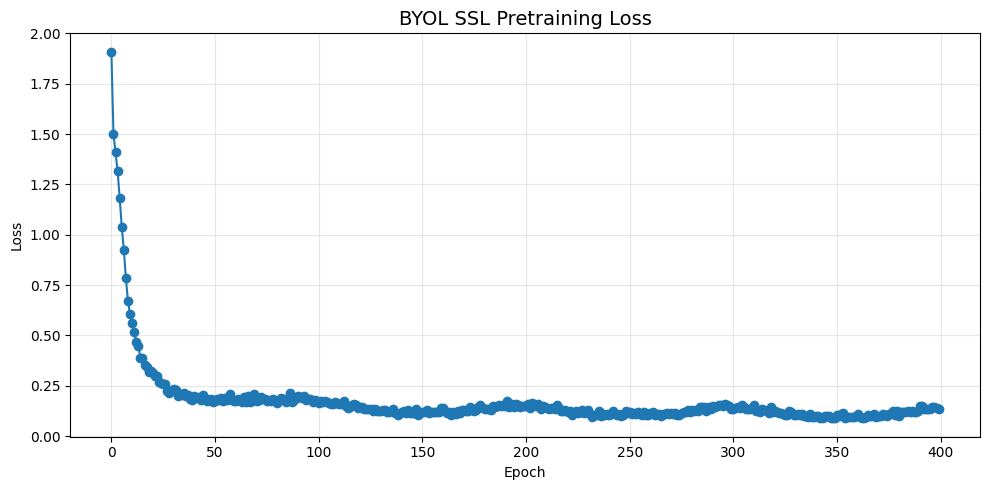

In [10]:
# ===============================================================
# Cell 10: SSL Pretraining Loop (FIXED)
# ===============================================================
epochs_ssl = 400
ssl_losses = []
best_ssl_loss = float('inf')

print("\n🔥 BYOL SSL Pretraining শুরু হচ্ছে...\n")

ssl_start_time = time.time()

for epoch in range(epochs_ssl):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    pbar = tqdm(ssl_loader, desc=f"Epoch {epoch+1}/{epochs_ssl}")
    
    for batch in pbar:
        # Unpack two views
        (view1, view2), _ = batch
        view1 = view1.to(device)
        view2 = view2.to(device)
        
        # Forward pass
        p1, t2, p2, t1 = model(view1, view2)
        
        # Loss calculation (symmetrized)
        loss = byol_loss(p1, t2).mean() + byol_loss(p2, t1).mean()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update target network
        model._update_target_network(momentum=0.996)
        
        epoch_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Learning rate scheduling
    scheduler.step()
    
    avg_loss = epoch_loss / num_batches
    ssl_losses.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{epochs_ssl} | SSL Loss: {avg_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if avg_loss < best_ssl_loss:
        best_ssl_loss = avg_loss
        torch.save(model.online_encoder.state_dict(), "best_byol_encoder.pth")
        print(f"✅ Best model saved at epoch {epoch+1}")

ssl_end_time = time.time()
ssl_time = ssl_end_time - ssl_start_time

print(f"\n✅ SSL Pretraining সম্পন্ন হয়েছে | Time: {ssl_time:.2f} seconds")

# Save final model
torch.save(model.online_encoder.state_dict(), "byol_resnet50_encoder.pth")

# Plot SSL loss
plt.figure(figsize=(10, 5))
plt.plot(ssl_losses, marker='o')
plt.title("BYOL SSL Pretraining Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("ssl_loss_curve.png", dpi=300)
plt.show()


In [11]:
# ===============================================================
# Cell 11: Load Best Encoder for Evaluation
# ===============================================================
num_classes = len(eval_dataset.classes)

# Load best encoder
encoder = models.resnet50(weights=None)
encoder.fc = nn.Identity()
encoder.load_state_dict(torch.load("best_byol_encoder.pth"), strict=False)
encoder = encoder.to(device)
encoder.eval()

# Freeze encoder
for param in encoder.parameters():
    param.requires_grad = False

print(f"✅ Best Encoder লোড হয়েছে | Classes: {num_classes}")

✅ Best Encoder লোড হয়েছে | Classes: 10



🎯 Linear Probe Training শুরু হচ্ছে...

Epoch 10/200 | Train Acc: 0.9170 | Val Acc: 0.8022
Epoch 20/200 | Train Acc: 0.9560 | Val Acc: 0.8132
Epoch 30/200 | Train Acc: 0.9719 | Val Acc: 0.8242
Epoch 40/200 | Train Acc: 0.9829 | Val Acc: 0.8022
Epoch 50/200 | Train Acc: 0.9841 | Val Acc: 0.8022
Epoch 60/200 | Train Acc: 0.9866 | Val Acc: 0.8132
Epoch 70/200 | Train Acc: 0.9927 | Val Acc: 0.8132
Epoch 80/200 | Train Acc: 0.9963 | Val Acc: 0.8352
Epoch 90/200 | Train Acc: 0.9988 | Val Acc: 0.8242
Epoch 100/200 | Train Acc: 0.9988 | Val Acc: 0.8352
Epoch 110/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 120/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 130/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 140/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 150/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 160/200 | Train Acc: 1.0000 | Val Acc: 0.8462
Epoch 170/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 180/200 | Train Acc: 1.0000 | Val Acc: 0.8352
Epoch 190/200 | Train Acc: 1.0000

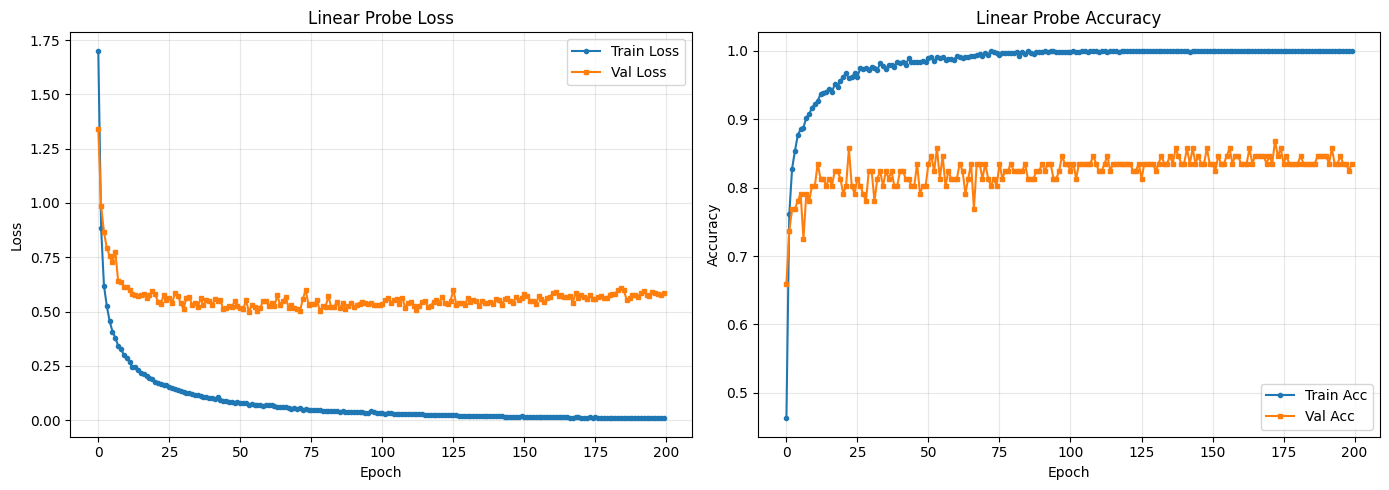

In [12]:
# ===============================================================
# Cell 12: Linear Probe Training (FIXED)
# ===============================================================
linear_head = nn.Linear(2048, num_classes).to(device)
optimizer_lp = optim.Adam(linear_head.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

epochs_lp = 200
train_accs_lp, val_accs_lp = [], []
train_losses_lp, val_losses_lp = [], []
best_val_acc = 0

print("\n🎯 Linear Probe Training শুরু হচ্ছে...\n")

lp_start_time = time.time()

for epoch in range(epochs_lp):
    # ============ TRAINING ============
    linear_head.train()
    total, correct, running_loss = 0, 0, 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Extract features (frozen encoder)
        with torch.no_grad():
            feats = encoder(imgs)
        
        # Linear probe forward
        outputs = linear_head(feats)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer_lp.zero_grad()
        loss.backward()
        optimizer_lp.step()
        
        # Metrics
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_loss = running_loss / total
    train_accs_lp.append(train_acc)
    train_losses_lp.append(train_loss)
    
    # ============ VALIDATION ============
    linear_head.eval()
    total, correct, val_loss = 0, 0, 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            feats = encoder(imgs)
            outputs = linear_head(feats)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total
    val_loss = val_loss / total
    val_accs_lp.append(val_acc)
    val_losses_lp.append(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(linear_head.state_dict(), "best_linear_probe.pth")
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_lp} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

lp_end_time = time.time()
lp_time = lp_end_time - lp_start_time

print(f"\n✅ Linear Probe Training সম্পন্ন | Time: {lp_time:.2f}s | Best Val Acc: {best_val_acc:.4f}")

# Load best linear probe
linear_head.load_state_dict(torch.load("best_linear_probe.pth"))

# Plot Linear Probe curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses_lp, label="Train Loss", marker='o', markersize=3)
axes[0].plot(val_losses_lp, label="Val Loss", marker='s', markersize=3)
axes[0].set_title("Linear Probe Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs_lp, label="Train Acc", marker='o', markersize=3)
axes[1].plot(val_accs_lp, label="Val Acc", marker='s', markersize=3)
axes[1].set_title("Linear Probe Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("linear_probe_curves.png", dpi=300)
plt.show()


In [13]:
# ===============================================================
# Cell 13: Test Set Evaluation (Linear Probe) - FIXED
# ===============================================================
print("\n📊 Test Set Evaluation (Linear Probe)...\n")

linear_head.eval()
all_preds, all_labels, all_probs = [], [], []

test_start_time = time.time()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = encoder(imgs)
        outputs = linear_head(feats)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

test_end_time = time.time()
test_time = test_end_time - test_start_time

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# ✅ FIX: Find which classes are actually present in test set
unique_test_labels = np.unique(all_labels)
present_class_names = [eval_dataset.classes[i] for i in unique_test_labels]

print(f"Classes in test set: {len(unique_test_labels)}/{num_classes}")
print(f"Present classes: {present_class_names}\n")

# Classification Report - শুধু present classes এর জন্য
print("📋 Classification Report:")
print(classification_report(
    all_labels, 
    all_preds, 
    labels=unique_test_labels,  # ✅ শুধু যেগুলো আছে
    target_names=present_class_names,  # ✅ শুধু সেগুলোর নাম
    zero_division=0
))

test_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Time: {test_time:.2f} seconds")


📊 Test Set Evaluation (Linear Probe)...

Classes in test set: 10/10
Present classes: ['Genus Criconemoides', 'Genus Helicotylenchus', 'Genus Hemicycliophora', 'Genus Hirschmaniella', 'Genus Hoplolaimus', 'Genus Meloidogyne', 'Genus Pratylenchus', 'Genus Radopholus', 'Genus Trichodorus', 'Genus Xiphinema']

📋 Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides       1.00      0.90      0.95        10
Genus Helicotylenchus       1.00      0.86      0.92        14
Genus Hemicycliophora       1.00      1.00      1.00         1
 Genus Hirschmaniella       0.82      0.69      0.75        13
    Genus Hoplolaimus       0.94      1.00      0.97        15
    Genus Meloidogyne       0.83      0.95      0.89        21
   Genus Pratylenchus       0.69      0.75      0.72        12
     Genus Radopholus       0.50      0.67      0.57         3
    Genus Trichodorus       0.67      0.50      0.57         4
      Genus Xiphinema       0.78   

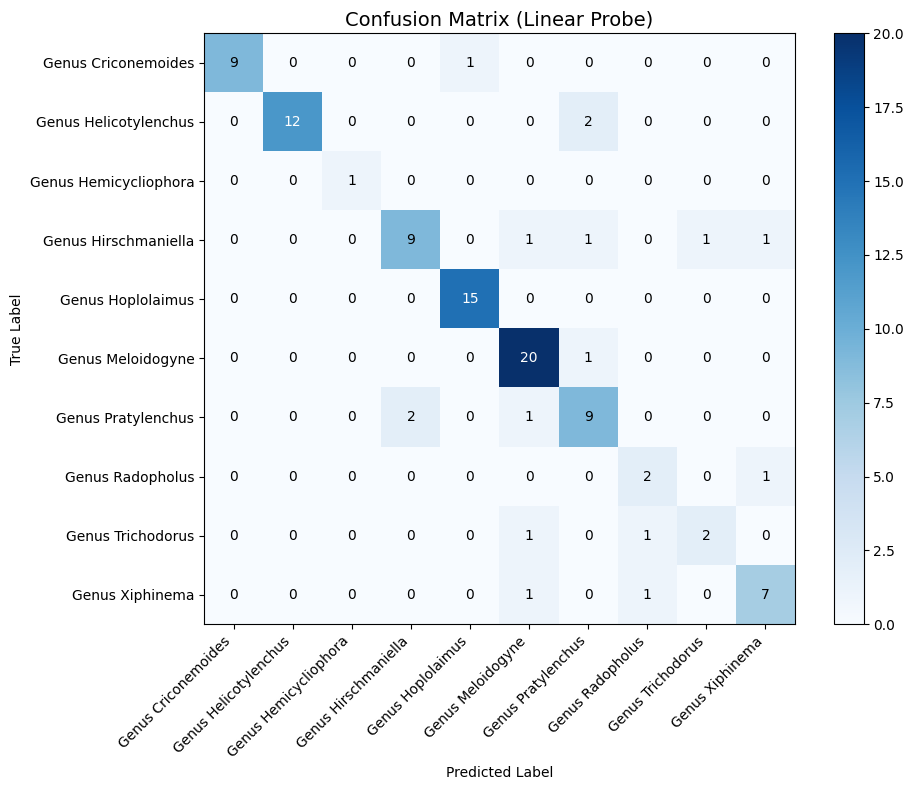

In [14]:
# ===============================================================
# Cell 14: Confusion Matrix - FIXED
# ===============================================================
# ✅ শুধু present classes এর জন্য confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_test_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues", interpolation='nearest')
plt.title("Confusion Matrix (Linear Probe)", fontsize=14)
plt.colorbar()

tick_marks = np.arange(len(unique_test_labels))
plt.xticks(tick_marks, present_class_names, rotation=45, ha='right')
plt.yticks(tick_marks, present_class_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

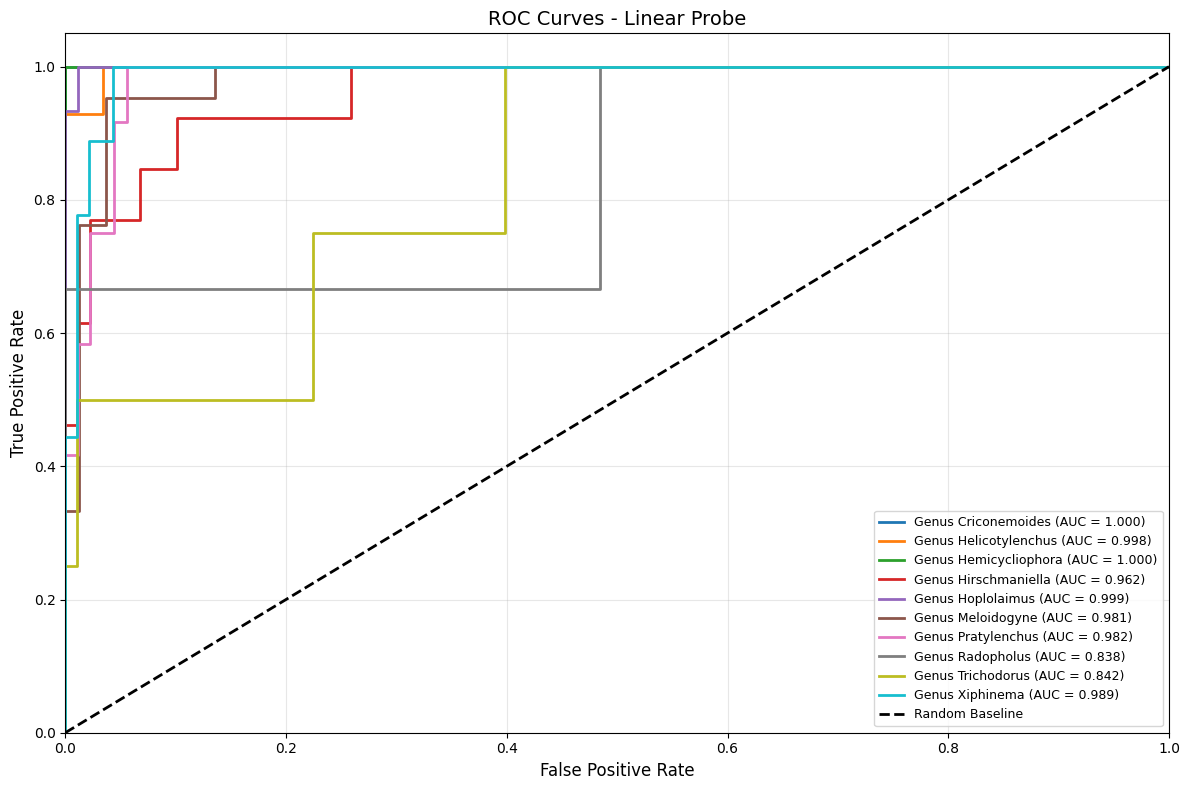

In [15]:
# ===============================================================
# Cell 15: ROC Curves and AUC - FIXED
# ===============================================================
from sklearn.preprocessing import label_binarize

# ✅ Binarize শুধু present classes এর জন্য
y_test_bin = label_binarize(all_labels, classes=unique_test_labels)

plt.figure(figsize=(12, 8))

# ✅ শুধু present classes এর ROC plot করুন
for idx, class_idx in enumerate(unique_test_labels):
    if y_test_bin[:, idx].sum() > 0:  # যদি class টা থাকে
        fpr, tpr, _ = roc_curve(y_test_bin[:, idx], all_probs[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, 
                label=f'{eval_dataset.classes[class_idx]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Linear Probe', fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300)
plt.show()

In [16]:
# ===============================================================
# Cell 16: Extract Test Embeddings
# ===============================================================
print("\n🔍 Extracting test embeddings...\n")

encoder.eval()
embeddings, labels_list = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = encoder(imgs)
        embeddings.append(feats.cpu().numpy())
        labels_list.extend(labels.numpy())

embeddings = np.vstack(embeddings).astype(np.float32)
labels_list = np.array(labels_list)

print(f"✅ Embeddings shape: {embeddings.shape}")


🔍 Extracting test embeddings...

✅ Embeddings shape: (102, 2048)


In [17]:
##............................cell 17 3 ta code ..........

🎨 Generating t-SNE visualization...
Using perplexity=25 for 102 samples
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 102 samples in 0.001s...
[t-SNE] Computed neighbors for 102 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 102 / 102
[t-SNE] Mean sigma: 6.212886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.781780
[t-SNE] KL divergence after 1000 iterations: 0.419941


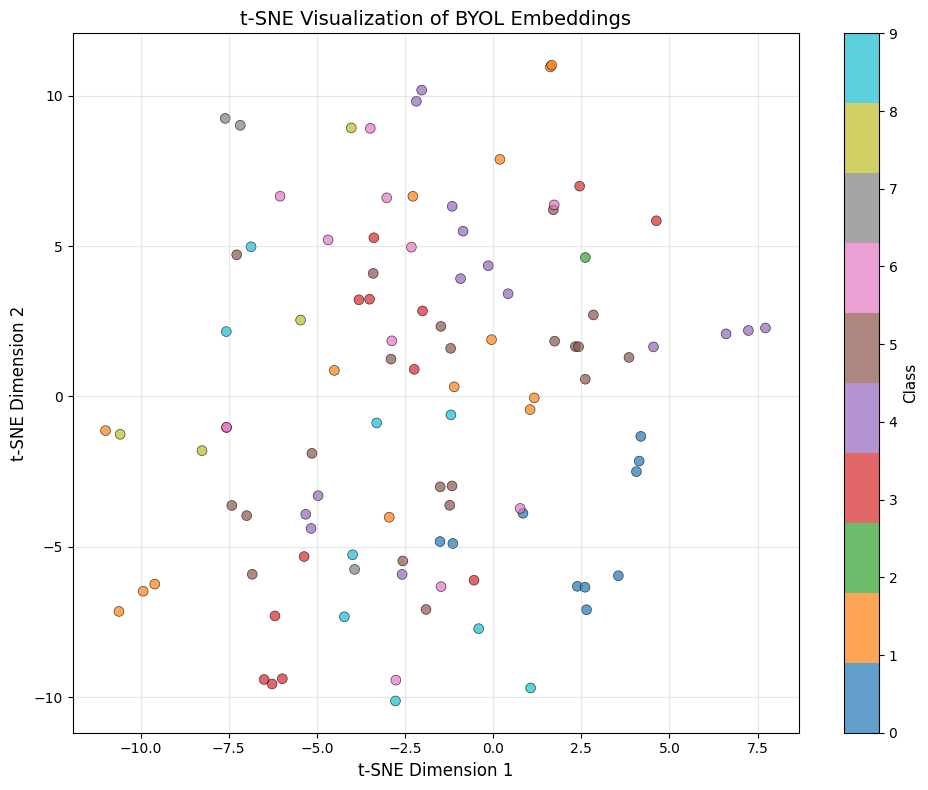

✅ t-SNE plot saved


In [18]:
# ===============================================================
# Cell 17: t-SNE Visualization - OPTIMIZED
# ===============================================================
print("🎨 Generating t-SNE visualization...")

# ✅ Dataset size এর উপর ভিত্তি করে perplexity adjust করুন
n_samples = embeddings.shape[0]
perplexity_value = min(30, n_samples // 4)  # Rule of thumb: n_samples/4

print(f"Using perplexity={perplexity_value} for {n_samples} samples")

tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=perplexity_value,  # ✅ Dynamic perplexity
    max_iter=1000,  # ✅ n_iter → max_iter
    verbose=1  # Show progress
)
tsne_emb = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], 
                     c=labels_list, cmap='tab10', 
                     s=50, alpha=0.7, edgecolors='k', linewidth=0.5)

# ✅ Colorbar শুধু present classes এর জন্য
cbar = plt.colorbar(scatter, ticks=range(num_classes))
cbar.set_label('Class', fontsize=11)

plt.title("t-SNE Visualization of BYOL Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("tsne_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ t-SNE plot saved")


🎨 Generating visualizations...

1️⃣ t-SNE visualization...


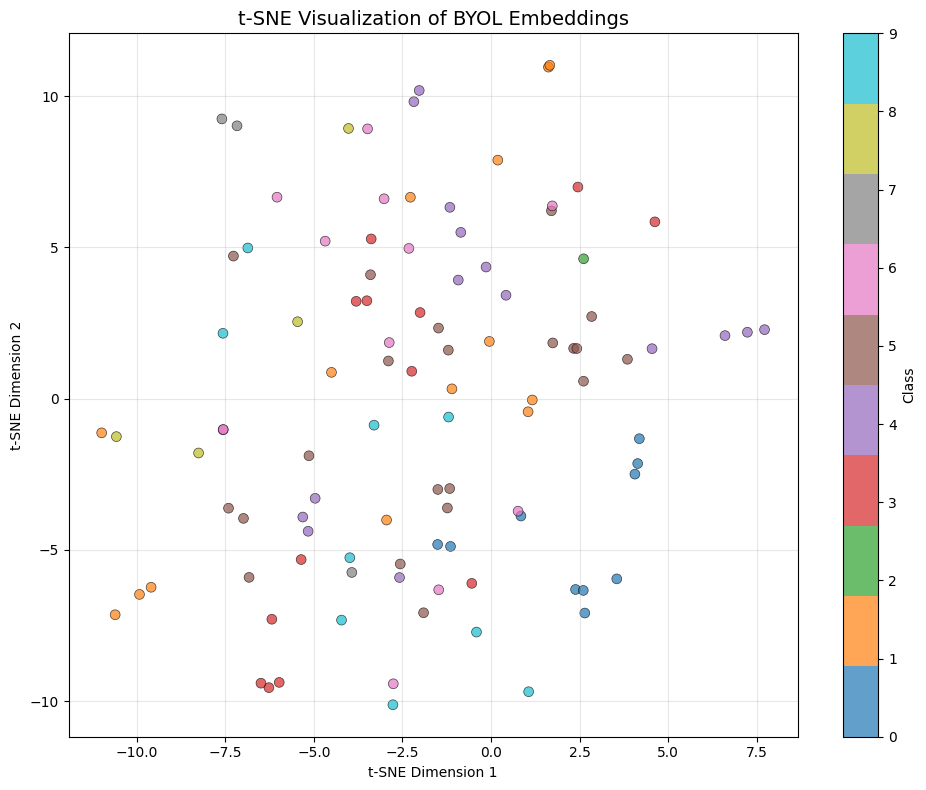

✅ t-SNE done

2️⃣ PCA visualization...
   Explained Variance: PC1=0.079, PC2=0.067


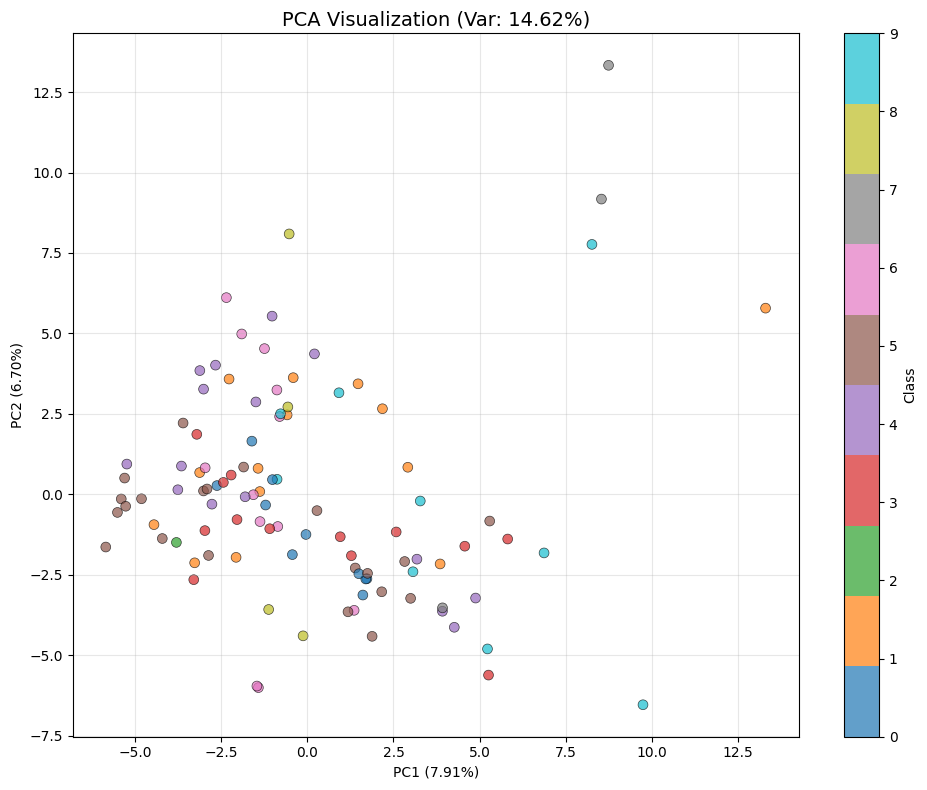

✅ PCA done

3️⃣ UMAP visualization...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


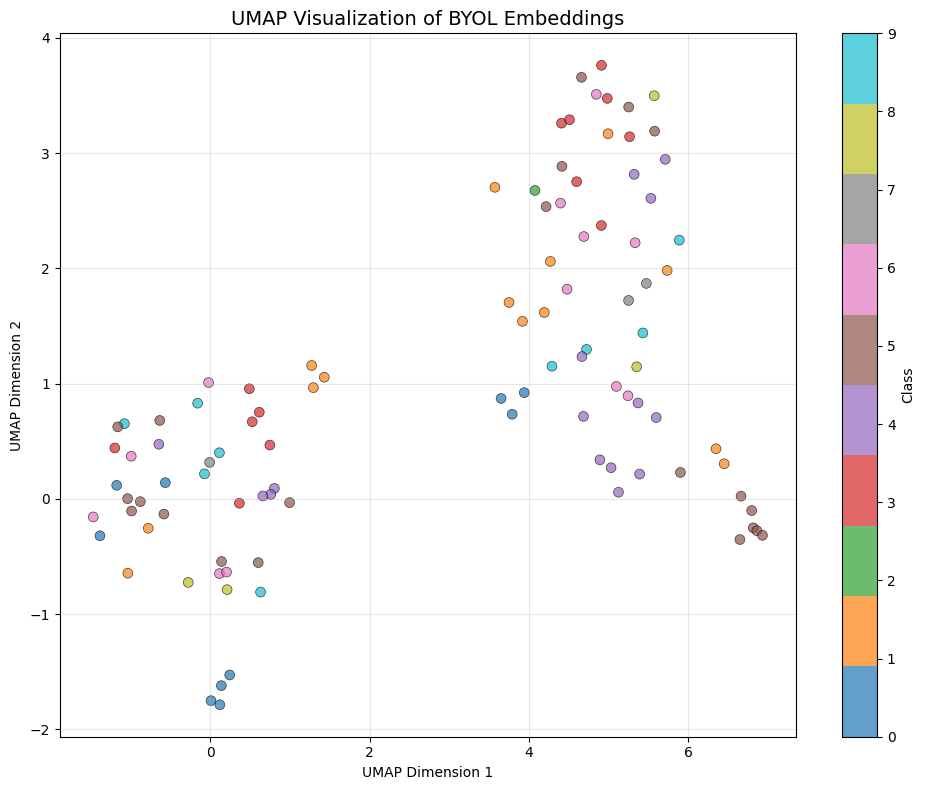

✅ UMAP done

✅ All visualizations completed!


In [19]:
# ===============================================================
# Cells 17-19: All Visualizations - FIXED
# ===============================================================

print("\n🎨 Generating visualizations...\n")

# Get dynamic perplexity
n_samples = embeddings.shape[0]
perplexity_value = min(30, max(5, n_samples // 4))

# ==================== t-SNE ====================
print("1️⃣ t-SNE visualization...")
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=perplexity_value,
    max_iter=1000,  # ✅ FIXED: n_iter → max_iter
    learning_rate='auto',
    init='pca'
)
tsne_emb = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], 
                     c=labels_list, cmap='tab10', 
                     s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, ticks=range(num_classes), label='Class')
plt.title("t-SNE Visualization of BYOL Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("tsne_plot.png", dpi=300)
plt.show()
print("✅ t-SNE done\n")

# ==================== PCA ====================
print("2️⃣ PCA visualization...")
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(embeddings)

explained_var = pca.explained_variance_ratio_
print(f"   Explained Variance: PC1={explained_var[0]:.3f}, PC2={explained_var[1]:.3f}")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_emb[:, 0], pca_emb[:, 1], 
                     c=labels_list, cmap='tab10', 
                     s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, ticks=range(num_classes), label='Class')
plt.title(f"PCA Visualization (Var: {sum(explained_var):.2%})", fontsize=14)
plt.xlabel(f"PC1 ({explained_var[0]:.2%})")
plt.ylabel(f"PC2 ({explained_var[1]:.2%})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("pca_plot.png", dpi=300)
plt.show()
print("✅ PCA done\n")

# ==================== UMAP ====================
print("3️⃣ UMAP visualization...")
n_neighbors_value = min(15, max(2, n_samples // 10))

reducer = umap.UMAP(
    n_components=2, 
    random_state=42, 
    n_neighbors=n_neighbors_value, 
    min_dist=0.1,
    metric='cosine'
)
umap_emb = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_emb[:, 0], umap_emb[:, 1], 
                     c=labels_list, cmap='tab10', 
                     s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, ticks=range(num_classes), label='Class')
plt.title("UMAP Visualization of BYOL Embeddings", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("umap_plot.png", dpi=300)
plt.show()
print("✅ UMAP done\n")

print("✅ All visualizations completed!")

In [20]:
# ===============================================================
# Cell 20: Silhouette Score
# ===============================================================
print("\n📏 Computing Silhouette Score...")

sil_score = silhouette_score(embeddings, labels_list, metric='cosine')
print(f"✅ Silhouette Score: {sil_score:.4f}")


📏 Computing Silhouette Score...
✅ Silhouette Score: 0.0047


In [21]:
#===============================================================
# Cell 21: k-NN Evaluation
# ===============================================================
print("\n🔎 k-NN Evaluation on Embeddings:\n")

for k in [1, 5, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(embeddings, labels_list)
    acc = knn.score(embeddings, labels_list)
    print(f"k-NN Accuracy (k={k}): {acc*100:.2f}%")



🔎 k-NN Evaluation on Embeddings:

k-NN Accuracy (k=1): 100.00%
k-NN Accuracy (k=5): 68.63%
k-NN Accuracy (k=20): 54.90%


In [22]:
# ===============================================================
# Cell 22: Shallow ML Classifiers
# ===============================================================
print("\n🤖 Shallow ML Classifiers on Frozen Embeddings:\n")

classifiers = {
    "MLP": MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=500, random_state=42),
    "SVM (Linear)": SVC(kernel="linear", probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, clf in classifiers.items():
    clf.fit(embeddings, labels_list)
    acc = clf.score(embeddings, labels_list)
    print(f"{name} Accuracy: {acc*100:.2f}%")



🤖 Shallow ML Classifiers on Frozen Embeddings:

MLP Accuracy: 100.00%
SVM (Linear) Accuracy: 100.00%
Decision Tree Accuracy: 100.00%
Random Forest Accuracy: 100.00%


In [23]:
# ===============================================================
# Cell 23: Full Fine-tuning Setup (FIXED)
# ===============================================================
print("\n🔧 Full Fine-tuning শুরু হচ্ছে...\n")

# Load encoder again for fine-tuning
finetuned_encoder = models.resnet50(weights=None)
finetuned_encoder.fc = nn.Linear(2048, num_classes)  # Classification head
finetuned_encoder.load_state_dict(torch.load("best_byol_encoder.pth"), strict=False)
finetuned_encoder = finetuned_encoder.to(device)

# Unfreeze all parameters
for param in finetuned_encoder.parameters():
    param.requires_grad = True

# Optimizer with different learning rates for backbone and head
optimizer_ft = optim.Adam([
    {'params': finetuned_encoder.layer4.parameters(), 'lr': 1e-5},
    {'params': finetuned_encoder.layer3.parameters(), 'lr': 5e-6},
    {'params': finetuned_encoder.fc.parameters(), 'lr': 1e-4}
], weight_decay=1e-5)

scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=50)
criterion_ft = nn.CrossEntropyLoss()


🔧 Full Fine-tuning শুরু হচ্ছে...



Epoch 10/200 | Train Acc: 0.9597 | Val Acc: 0.8791
Epoch 20/200 | Train Acc: 0.9963 | Val Acc: 0.9121
Epoch 30/200 | Train Acc: 1.0000 | Val Acc: 0.9011
Epoch 40/200 | Train Acc: 1.0000 | Val Acc: 0.9231
Epoch 50/200 | Train Acc: 1.0000 | Val Acc: 0.9121
Epoch 60/200 | Train Acc: 0.9963 | Val Acc: 0.9231
Epoch 70/200 | Train Acc: 1.0000 | Val Acc: 0.9011
Epoch 80/200 | Train Acc: 1.0000 | Val Acc: 0.9011
Epoch 90/200 | Train Acc: 1.0000 | Val Acc: 0.9011
Epoch 100/200 | Train Acc: 1.0000 | Val Acc: 0.9231
Epoch 110/200 | Train Acc: 1.0000 | Val Acc: 0.9231
Epoch 120/200 | Train Acc: 1.0000 | Val Acc: 0.9231
Epoch 130/200 | Train Acc: 1.0000 | Val Acc: 0.9341
Epoch 140/200 | Train Acc: 1.0000 | Val Acc: 0.9121
Epoch 150/200 | Train Acc: 1.0000 | Val Acc: 0.9231
Epoch 160/200 | Train Acc: 1.0000 | Val Acc: 0.9341
Epoch 170/200 | Train Acc: 1.0000 | Val Acc: 0.9341
Epoch 180/200 | Train Acc: 1.0000 | Val Acc: 0.9231
Epoch 190/200 | Train Acc: 1.0000 | Val Acc: 0.9121
Epoch 200/200 | Train

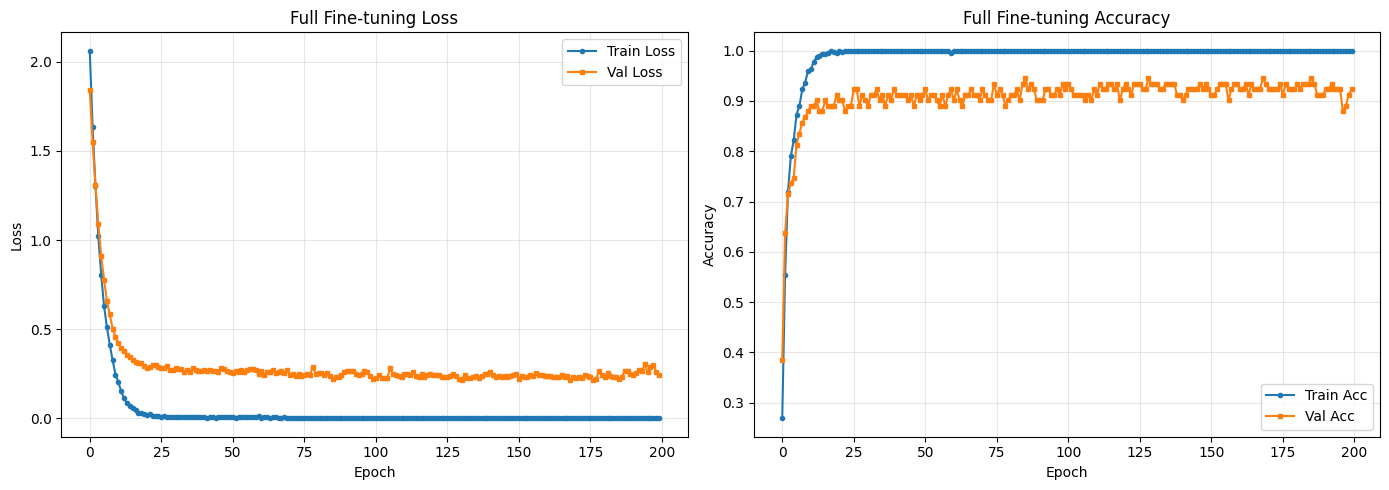

In [24]:
# ===============================================================
# Cell 24: Full Fine-tuning Training Loop
# ===============================================================
epochs_ft = 200
train_accs_ft, val_accs_ft = [], []
train_losses_ft, val_losses_ft = [], []
best_val_acc_ft = 0

ft_start_time = time.time()

for epoch in range(epochs_ft):
    # ============ TRAINING ============
    finetuned_encoder.train()
    total, correct, running_loss = 0, 0, 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        outputs = finetuned_encoder(imgs)
        loss = criterion_ft(outputs, labels)
        
        optimizer_ft.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(finetuned_encoder.parameters(), max_norm=1.0)
        optimizer_ft.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc_ft = correct / total
    train_loss_ft = running_loss / total
    train_accs_ft.append(train_acc_ft)
    train_losses_ft.append(train_loss_ft)
    
    # ============ VALIDATION ============
    finetuned_encoder.eval()
    total, correct, val_loss = 0, 0, 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = finetuned_encoder(imgs)
            loss = criterion_ft(outputs, labels)
            
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_acc_ft = correct / total
    val_loss_ft = val_loss / total
    val_accs_ft.append(val_acc_ft)
    val_losses_ft.append(val_loss_ft)
    
    # Scheduler step
    scheduler_ft.step()
    
    # Save best model
    if val_acc_ft > best_val_acc_ft:
        best_val_acc_ft = val_acc_ft
        torch.save(finetuned_encoder.state_dict(), "best_finetuned_encoder.pth")
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_ft} | Train Acc: {train_acc_ft:.4f} | Val Acc: {val_acc_ft:.4f}")

ft_end_time = time.time()
ft_time = ft_end_time - ft_start_time

print(f"\n✅ Fine-tuning সম্পন্ন | Time: {ft_time:.2f}s | Best Val Acc: {best_val_acc_ft:.4f}")

# Load best fine-tuned model
finetuned_encoder.load_state_dict(torch.load("best_finetuned_encoder.pth"))

# Plot fine-tuning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses_ft, label="Train Loss", marker='o', markersize=3)
axes[0].plot(val_losses_ft, label="Val Loss", marker='s', markersize=3)
axes[0].set_title("Full Fine-tuning Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs_ft, label="Train Acc", marker='o', markersize=3)
axes[1].plot(val_accs_ft, label="Val Acc", marker='s', markersize=3)
axes[1].set_title("Full Fine-tuning Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("finetuning_curves.png", dpi=300)
plt.show()


In [25]:
# ===============================================================
# Cell 25: Test Evaluation (Fine-tuned Model)
# ===============================================================
print("\n📊 Test Set Evaluation (Fine-tuned Model)...\n")

finetuned_encoder.eval()
all_preds_ft, all_labels_ft, all_probs_ft = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = finetuned_encoder(imgs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds_ft.extend(preds.cpu().numpy())
        all_labels_ft.extend(labels.numpy())
        all_probs_ft.extend(probs.cpu().numpy())

all_labels_ft = np.array(all_labels_ft)
all_preds_ft = np.array(all_preds_ft)
all_probs_ft = np.array(all_probs_ft)

# Classification Report
print("📋 Classification Report (Fine-tuned):")
print(classification_report(all_labels_ft, all_preds_ft, target_names=eval_dataset.classes, zero_division=0))

test_acc_ft = (all_preds_ft == all_labels_ft).sum() / len(all_labels_ft)
print(f"\n✅ Test Accuracy (Fine-tuned): {test_acc_ft:.4f}")


📊 Test Set Evaluation (Fine-tuned Model)...

📋 Classification Report (Fine-tuned):
                       precision    recall  f1-score   support

  Genus Criconemoides       1.00      1.00      1.00        10
Genus Helicotylenchus       1.00      0.93      0.96        14
Genus Hemicycliophora       0.00      0.00      0.00         1
 Genus Hirschmaniella       0.85      0.85      0.85        13
    Genus Hoplolaimus       1.00      0.93      0.97        15
    Genus Meloidogyne       0.80      0.95      0.87        21
   Genus Pratylenchus       0.89      0.67      0.76        12
     Genus Radopholus       0.50      0.67      0.57         3
    Genus Trichodorus       0.67      0.50      0.57         4
      Genus Xiphinema       0.73      0.89      0.80         9

             accuracy                           0.86       102
            macro avg       0.74      0.74      0.73       102
         weighted avg       0.86      0.86      0.86       102


✅ Test Accuracy (Fine-tuned): 


📈 Linear Probe vs Full Fine-tuning Comparison:

Linear Probe Test Acc: 0.8431
Fine-tuned Test Acc:   0.8627
Improvement:           1.96%


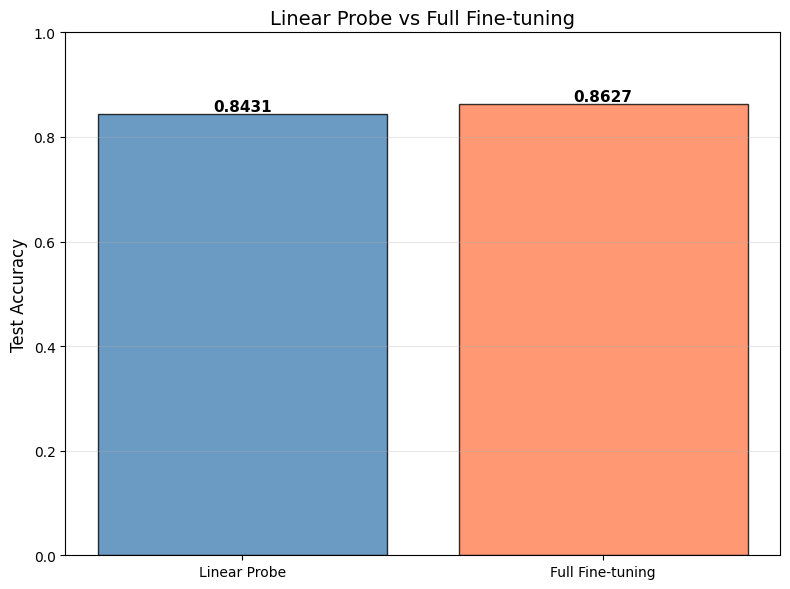

In [26]:
# ===============================================================
# Cell 26: Comparison - Linear Probe vs Fine-tuning
# ===============================================================
print("\n📈 Linear Probe vs Full Fine-tuning Comparison:\n")
print(f"Linear Probe Test Acc: {test_acc:.4f}")
print(f"Fine-tuned Test Acc:   {test_acc_ft:.4f}")
print(f"Improvement:           {(test_acc_ft - test_acc)*100:.2f}%")

# Bar plot comparison
fig, ax = plt.subplots(figsize=(8, 6))
methods = ['Linear Probe', 'Full Fine-tuning']
accuracies = [test_acc, test_acc_ft]
colors = ['steelblue', 'coral']

bars = ax.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Linear Probe vs Full Fine-tuning', fontsize=14)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("linear_vs_finetuning.png", dpi=300)
plt.show()


In [27]:
# ===============================================================
# Cell 27: Label Efficiency Experiment (FIXED)
# ===============================================================
print("\n🔬 Label Efficiency Experiment...\n")

label_ratios = [0.01, 0.05, 0.10, 0.25, 0.50]
subset_train_accs = []
subset_val_accs = []

for ratio in label_ratios:
    print(f"\n--- Training with {int(ratio*100)}% labeled data ---")
    
    subset_size = max(1, int(len(train_indices) * ratio))
    subset_indices = random.sample(train_indices, subset_size)
    subset_dataset = Subset(eval_dataset, subset_indices)
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
    
    # Reset linear head
    linear_head_sub = nn.Linear(2048, num_classes).to(device)
    optimizer_sub = optim.Adam(linear_head_sub.parameters(), lr=1e-3)
    criterion_sub = nn.CrossEntropyLoss()
    
    epochs_sub = 150
    best_sub_val_acc = 0
    
    for epoch in range(epochs_sub):
        # Train
        linear_head_sub.train()
        total, correct = 0, 0
        
        for imgs, labels in subset_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            with torch.no_grad():
                feats = encoder(imgs)
            
            outputs = linear_head_sub(feats)
            loss = criterion_sub(outputs, labels)
            
            optimizer_sub.zero_grad()
            loss.backward()
            optimizer_sub.step()
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc_sub = correct / total
        
        # Validation
        linear_head_sub.eval()
        total, correct = 0, 0
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                feats = encoder(imgs)
                outputs = linear_head_sub(feats)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_acc_sub = correct / total
        
        if val_acc_sub > best_sub_val_acc:
            best_sub_val_acc = val_acc_sub
    
    subset_train_accs.append(train_acc_sub)
    subset_val_accs.append(best_sub_val_acc)
    
    print(f"✅ {int(ratio*100)}% labels | Train Acc: {train_acc_sub:.4f} | Val Acc: {best_sub_val_acc:.4f}")



🔬 Label Efficiency Experiment...


--- Training with 1% labeled data ---
✅ 1% labels | Train Acc: 1.0000 | Val Acc: 0.2747

--- Training with 5% labeled data ---
✅ 5% labels | Train Acc: 1.0000 | Val Acc: 0.4835

--- Training with 10% labeled data ---
✅ 10% labels | Train Acc: 1.0000 | Val Acc: 0.6044

--- Training with 25% labeled data ---
✅ 25% labels | Train Acc: 1.0000 | Val Acc: 0.7473

--- Training with 50% labeled data ---
✅ 50% labels | Train Acc: 1.0000 | Val Acc: 0.8571


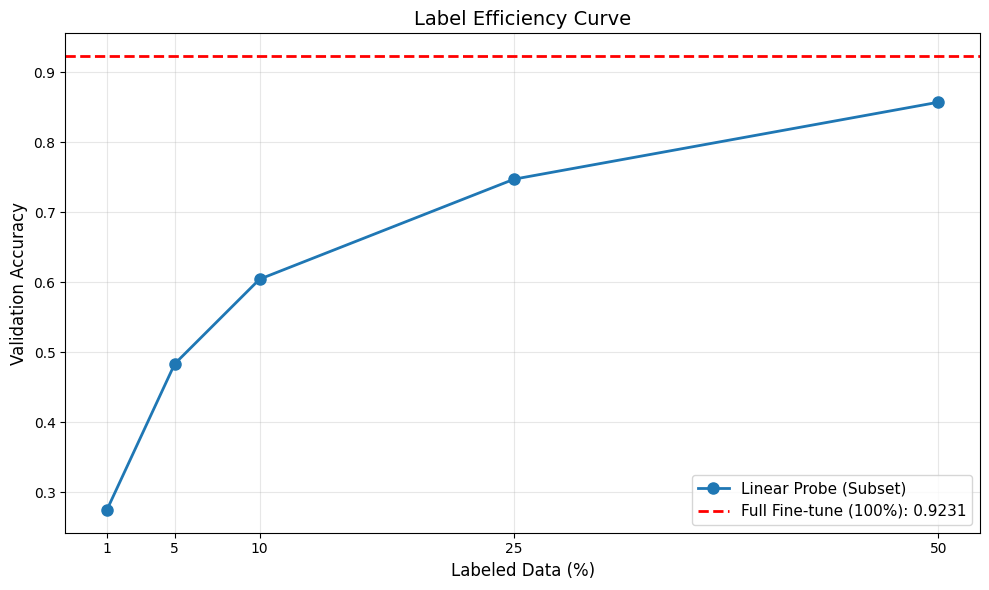

In [28]:
# ===============================================================
# Cell 28: Label Efficiency Curve Plot
# ===============================================================
plt.figure(figsize=(10, 6))
plt.plot([r*100 for r in label_ratios], subset_val_accs, 
         marker='o', linewidth=2, markersize=8, label="Linear Probe (Subset)")
plt.axhline(y=val_accs_ft[-1], color='r', linestyle='--', 
            linewidth=2, label=f"Full Fine-tune (100%): {val_accs_ft[-1]:.4f}")
plt.xlabel("Labeled Data (%)", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Label Efficiency Curve", fontsize=14)
plt.xticks([r*100 for r in label_ratios])
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("label_efficiency_curve.png", dpi=300)
plt.show()

In [29]:
# ===============================================================
# Cell 29: Model Complexity Analysis (GFLOPs & Parameters)
# ===============================================================
print("\n⚙️ Model Complexity Analysis:\n")

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Linear Probe (Encoder + Linear Head)
encoder_test = models.resnet50(weights=None)
encoder_test.fc = nn.Identity()
encoder_test = encoder_test.to(device)
encoder_test.eval()

flops_encoder, params_encoder = profile(encoder_test, inputs=(dummy_input,), verbose=False)

linear_head_test = nn.Linear(2048, num_classes).to(device)
dummy_feats = torch.randn(1, 2048).to(device)
flops_head, params_head = profile(linear_head_test, inputs=(dummy_feats,), verbose=False)

total_flops_lp = flops_encoder + flops_head
total_params_lp = params_encoder + params_head

print(f"Linear Probe:")
print(f"  FLOPs:  {total_flops_lp/1e9:.2f} GFLOPs")
print(f"  Params: {total_params_lp/1e6:.2f} Million\n")

# Fine-tuned Model
finetuned_test = models.resnet50(weights=None)
finetuned_test.fc = nn.Linear(2048, num_classes)
finetuned_test = finetuned_test.to(device)
finetuned_test.eval()

flops_ft, params_ft = profile(finetuned_test, inputs=(dummy_input,), verbose=False)

print(f"Fine-tuned Model:")
print(f"  FLOPs:  {flops_ft/1e9:.2f} GFLOPs")
print(f"  Params: {params_ft/1e6:.2f} Million")


⚙️ Model Complexity Analysis:

Linear Probe:
  FLOPs:  4.13 GFLOPs
  Params: 23.51 Million

Fine-tuned Model:
  FLOPs:  4.13 GFLOPs
  Params: 23.53 Million


In [30]:
# ===============================================================
# Cell 30: Final Summary Report
# ===============================================================
print("\n" + "="*60)
print("📊 FINAL SUMMARY REPORT")
print("="*60)

print("\n🔥 SSL Pretraining (BYOL):")
print(f"  Epochs:        {epochs_ssl}")
print(f"  Final Loss:    {ssl_losses[-1]:.4f}")
print(f"  Training Time: {ssl_time:.2f} seconds")

print("\n🎯 Linear Probe:")
print(f"  Best Val Acc:  {best_val_acc:.4f}")
print(f"  Test Acc:      {test_acc:.4f}")
print(f"  Training Time: {lp_time:.2f} seconds")
print(f"  Test Time:     {test_time:.2f} seconds")

print("\n🔧 Full Fine-tuning:")
print(f"  Best Val Acc:  {best_val_acc_ft:.4f}")
print(f"  Test Acc:      {test_acc_ft:.4f}")
print(f"  Training Time: {ft_time:.2f} seconds")
print(f"  Improvement:   {(test_acc_ft - test_acc)*100:.2f}%")

print("\n📏 Embedding Quality:")
print(f"  Silhouette Score: {sil_score:.4f}")

print("\n🔎 k-NN Accuracy:")
for k in [1, 5, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(embeddings, labels_list)
    acc = knn.score(embeddings, labels_list)
    print(f"  k={k:2d}: {acc*100:.2f}%")

print("\n⚙️ Model Complexity:")
print(f"  FLOPs:  {total_flops_lp/1e9:.2f} GFLOPs")
print(f"  Params: {total_params_lp/1e6:.2f} Million")

print("\n🔬 Label Efficiency (Val Acc):")
for ratio, val_acc in zip(label_ratios, subset_val_accs):
    print(f"  {int(ratio*100):3d}%: {val_acc:.4f}")

print("\n" + "="*60)
print("✅ All experiments completed successfully!")
print("="*60)


📊 FINAL SUMMARY REPORT

🔥 SSL Pretraining (BYOL):
  Epochs:        400
  Final Loss:    0.1342
  Training Time: 32283.97 seconds

🎯 Linear Probe:
  Best Val Acc:  0.8681
  Test Acc:      0.8431
  Training Time: 2118.81 seconds
  Test Time:     2.11 seconds

🔧 Full Fine-tuning:
  Best Val Acc:  0.9451
  Test Acc:      0.8627
  Training Time: 2493.41 seconds
  Improvement:   1.96%

📏 Embedding Quality:
  Silhouette Score: 0.0047

🔎 k-NN Accuracy:
  k= 1: 100.00%
  k= 5: 68.63%
  k=20: 54.90%

⚙️ Model Complexity:
  FLOPs:  4.13 GFLOPs
  Params: 23.51 Million

🔬 Label Efficiency (Val Acc):
    1%: 0.2747
    5%: 0.4835
   10%: 0.6044
   25%: 0.7473
   50%: 0.8571

✅ All experiments completed successfully!


In [31]:
# ===============================================================
# Cell 31: Save All Results to Dictionary
# ===============================================================
results = {
    "ssl_pretraining": {
        "epochs": epochs_ssl,
        "final_loss": ssl_losses[-1],
        "training_time": ssl_time,
        "losses": ssl_losses
    },
    "linear_probe": {
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "training_time": lp_time,
        "test_time": test_time,
        "train_accs": train_accs_lp,
        "val_accs": val_accs_lp
    },
    "fine_tuning": {
        "best_val_acc": best_val_acc_ft,
        "test_acc": test_acc_ft,
        "training_time": ft_time,
        "train_accs": train_accs_ft,
        "val_accs": val_accs_ft
    },
    "embeddings": {
        "silhouette_score": sil_score
    },
    "label_efficiency": {
        "ratios": label_ratios,
        "val_accs": subset_val_accs
    },
    "model_complexity": {
        "flops_gflops": total_flops_lp/1e9,
        "params_millions": total_params_lp/1e6
    }
}

# Save to file
import json
with open("byol_results.json", "w") as f:
    json.dump({k: {ki: vi if not isinstance(vi, list) else [float(v) for v in vi] 
                   for ki, vi in v.items()} 
              for k, v in results.items()}, f, indent=2)

print("\n✅ Results saved to byol_results.json")



✅ Results saved to byol_results.json


In [32]:
# ===============================================================
# Cell 32: Create Comparison Table
# ===============================================================
import pandas as pd

comparison_data = {
    "Method": ["Linear Probe", "Full Fine-tuning"],
    "Val Accuracy": [f"{best_val_acc:.4f}", f"{best_val_acc_ft:.4f}"],
    "Test Accuracy": [f"{test_acc:.4f}", f"{test_acc_ft:.4f}"],
    "Training Time (s)": [f"{lp_time:.2f}", f"{ft_time:.2f}"],
    "Parameters": [f"{total_params_lp/1e6:.2f}M", f"{params_ft/1e6:.2f}M"],
    "FLOPs": [f"{total_flops_lp/1e9:.2f}G", f"{flops_ft/1e9:.2f}G"]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 Comparison Table:")
print(df_comparison.to_string(index=False))

# Save to CSV
df_comparison.to_csv("comparison_table.csv", index=False)
print("\n✅ Comparison table saved to comparison_table.csv")

print("\n🎉 All tasks completed! Check the saved files for results.")


📊 Comparison Table:
          Method Val Accuracy Test Accuracy Training Time (s) Parameters FLOPs
    Linear Probe       0.8681        0.8431           2118.81     23.51M 4.13G
Full Fine-tuning       0.9451        0.8627           2493.41     23.53M 4.13G

✅ Comparison table saved to comparison_table.csv

🎉 All tasks completed! Check the saved files for results.
